# Manuscript Figures: 100-Gene Embryonic vs Endothelial

This notebook reproduces the requested figures using only the 100-gene embryonic and endothelial runs.


## 1. Environment Setup


In [19]:
from __future__ import annotations

from dataclasses import dataclass, replace
from datetime import datetime
from fnmatch import fnmatch
from pathlib import Path
from typing import Iterable, Optional, Sequence

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display, Image

# Configure plotting defaults for consistent styling
sns.set_theme(style="whitegrid", context="paper")
sns.set_context("paper", font_scale=1.1)
plt.rcParams.update({"figure.dpi": 160, "savefig.dpi": 320})
pd.options.display.max_columns = 120
pd.options.display.width = 180


In [20]:
# Parameter: Set GENE_COUNT to 100 or 1000 to control which dataset to analyze
GENE_COUNT = 100  # Change to 100 for 100-gene analysis

## 2. Analysis Configuration


In [21]:
# Centralised configuration for the notebook run
@dataclass
class AnalysisConfig:
    project_root: Path
    results_root: Path
    lookup_path: Path
    fig_dir: Path
    reports_dir: Path
    run_include_globs: tuple[str, ...] = ("*",)
    run_exclude: tuple[str, ...] = tuple()
    primary_split: str = "test"
    val_split: str = "val"
    train_split: str = "train"
    top_gene_count: int = 15
    top_model_count: int = 3
    random_seed: int = 7

    def __post_init__(self) -> None:
        # Create required directories if they are missing.
        self.fig_dir.mkdir(parents=True, exist_ok=True)
        self.reports_dir.mkdir(parents=True, exist_ok=True)
        self.lookup_path.parent.mkdir(parents=True, exist_ok=True)


project_root = Path.cwd().resolve()
while project_root.name in {"analysis", "scripts"}:
    project_root = project_root.parent

config = AnalysisConfig(
    project_root=project_root,
    results_root=project_root / "output" / "results" / "grn_regression_cellwise",
    lookup_path=project_root / "analysis" / "model_name_lookup.tsv",
    fig_dir=project_root / "analysis" / "figs" / f"manuscript_{GENE_COUNT}genes",
    reports_dir=project_root / "analysis" / "reports" / f"manuscript_{GENE_COUNT}genes",
    run_include_globs=(f"grn_{GENE_COUNT}genes_*",),
    run_exclude=tuple(),
    random_seed=7,
    top_gene_count=15,
    top_model_count=3,
)

if not config.results_root.exists():
    raise FileNotFoundError(f"Results directory missing: {config.results_root}")
if not config.lookup_path.exists():
    # Seed the lookup table if it is missing so later steps can append to it.
    pd.DataFrame({
        "model_id": [],
        "model_display_name": [],
        "model_short_name": [],
    }).to_csv(
        config.lookup_path, sep="\t", index=False
    )

np.random.seed(config.random_seed)
rng = np.random.default_rng(config.random_seed)
FIGURES: dict[str, plt.Figure] = {}
TABLES: dict[str, pd.DataFrame] = {}
EXTRA_EXPORT_PATHS: list[tuple[Path, str]] = []
analysis_metadata: dict[str, object] = {
    "generated_at": datetime.now().isoformat(timespec="seconds"),
    "project_root": config.project_root,
    "results_root": config.results_root,
}


## 3. Run Discovery Utilities


In [22]:
# Canonical representation of a single trained model output folder
@dataclass(frozen=True)
class RunRecord:
    run_name: str
    model_id: str
    run_path: Path
    model_path: Path
    metrics_path: Optional[Path]
    predictions_path: Optional[Path]
    training_history_path: Optional[Path]
    model_display: Optional[str] = None


LOOKUP_SPECIAL_CASES = {
    "cnn": "Convolutional Neural Network",
    "rnn": "Recurrent Neural Network",
    "lstm": "Long Short-Term Memory",
    "mlp": "Multilayer Perceptron",
    "svr": "Support Vector Regressor",
    "ols": "Ordinary Least Squares",
    "xgboost": "XGBoost",
    "catboost": "CatBoost",
    "hist_gradient_boosting": "Histogram Gradient Boosting",
    "extra_trees": "Extra Trees",
    "random_forest": "Random Forest",
    "elastic_net": "Elastic Net",
}

SHORT_NAME_FALLBACKS = {
    "Multilayer Perceptron": "MLP",
    "Graph Neural Network": "GNN",
    "Convolutional Neural Network": "CNN",
    "Long Short-Term Memory Network": "LSTM",
    "Recurrent Neural Network": "RNN",
    "Transformer Encoder": "Transformer",
    "Ordinary Least Squares": "OLS",
    "Extra Trees": "Extra Trees",
    "Random Forest": "Random Forest",
    "Ridge Regression": "Ridge",
}

MODEL_ID_TO_DISPLAY: dict[str, str] = {}
MODEL_ID_TO_SHORT: dict[str, str] = {}
MODEL_DISPLAY_TO_SHORT: dict[str, str] = {}


def _default_short_name(display_name: str) -> str:
    # Generate a lightweight abbreviation when none is provided.
    if not isinstance(display_name, str) or not display_name.strip():
        return ""
    tokens = [token for token in display_name.replace("(", " ").replace(")", " ").split() if token]
    if not tokens:
        return display_name
    acronym = "".join(token[0] for token in tokens if token and token[0].isalnum()).upper()
    if 1 < len(acronym) <= 5:
        return acronym
    return display_name


def compute_heatmap_limits(
    values: pd.DataFrame | np.ndarray,
    lower_percentile: float = 5.0,
    upper_percentile: float = 95.0,
    clip: tuple[float, float] = (0.0, 1.0),
    min_buffer: float = 0.01,
) -> tuple[float, float]:
    # Derive consistent vmin/vmax bounds so heatmaps emphasise the dense value range.
    data = np.asarray(values, dtype=float)
    data = data[np.isfinite(data)]
    if data.size == 0:
        return clip
    lower = np.percentile(data, lower_percentile)
    upper = np.percentile(data, upper_percentile)
    buffer = max(min_buffer, (upper - lower) * 0.05)
    vmin = max(clip[0], lower - buffer)
    vmax = min(clip[1], upper + buffer)
    if np.isclose(vmin, vmax):
        spread = max(min_buffer, abs(vmin) * 0.1 or min_buffer)
        vmin = max(clip[0], vmin - spread)
        vmax = min(clip[1], vmax + spread)
    return vmin, vmax


def to_short_name(name: str | None) -> str:
    # Return a concise display name for figure titles and filenames.
    if not name:
        return ""
    if name in MODEL_DISPLAY_TO_SHORT:
        return MODEL_DISPLAY_TO_SHORT[name]
    return SHORT_NAME_FALLBACKS.get(name, name)


def _read_lookup_table(path: Path) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        return pd.DataFrame({
            "model_id": pd.Series(dtype="string"),
            "model_display_name": pd.Series(dtype="string"),
            "model_short_name": pd.Series(dtype="string"),
        })
    df = pd.read_csv(path, sep="	")
    expected = {"model_id", "model_display_name"}
    missing_cols = expected.difference(df.columns)
    if missing_cols:
        raise ValueError(f"Lookup table missing required columns: {sorted(missing_cols)}")
    if "model_short_name" not in df.columns:
        df["model_short_name"] = df["model_display_name"].map(_default_short_name)
    else:
        df["model_short_name"] = df["model_short_name"].fillna("")
        missing_short = df["model_short_name"].str.strip() == ""
        df.loc[missing_short, "model_short_name"] = df.loc[missing_short, "model_display_name"].map(_default_short_name)
    return df


def _update_model_name_maps(df: pd.DataFrame) -> None:
    # Cache name lookups for downstream plotting helpers.
    global MODEL_ID_TO_DISPLAY, MODEL_ID_TO_SHORT, MODEL_DISPLAY_TO_SHORT
    if df.empty:
        MODEL_ID_TO_DISPLAY = {}
        MODEL_ID_TO_SHORT = {}
        MODEL_DISPLAY_TO_SHORT = {}
        return
    standardised = df.fillna("")
    MODEL_ID_TO_DISPLAY = {
        row.model_id: row.model_display_name or _guess_display_name(row.model_id)
        for row in standardised.itertuples(index=False)
    }
    MODEL_ID_TO_SHORT = {
        row.model_id: (row.model_short_name or MODEL_ID_TO_DISPLAY[row.model_id])
        for row in standardised.itertuples(index=False)
    }
    MODEL_DISPLAY_TO_SHORT = {
        MODEL_ID_TO_DISPLAY[row.model_id]: MODEL_ID_TO_SHORT[row.model_id]
        for row in standardised.itertuples(index=False)
    }


def _guess_display_name(model_id: str) -> str:
    if model_id in LOOKUP_SPECIAL_CASES:
        return LOOKUP_SPECIAL_CASES[model_id]
    parts = [part for part in model_id.replace("-", " ").replace("_", " ").split(" ") if part]
    if not parts:
        return model_id
    formatted = []
    for token in parts:
        if len(token) <= 3:
            formatted.append(token.upper())
        else:
            formatted.append(token.capitalize())
    return " ".join(formatted)


def _matches_any(value: str, patterns: Iterable[str]) -> bool:
    return any(fnmatch(value, pattern) for pattern in patterns) if patterns else False


def _first_existing(path: Path, candidates: Sequence[str]) -> Optional[Path]:
    for name in candidates:
        candidate = path / name
        if candidate.exists():
            return candidate
    return None


def discover_model_runs(
    results_root: Path,
    include_globs: Iterable[str],
    exclude_patterns: Iterable[str],
) -> list[RunRecord]:
    results_root = Path(results_root)
    if not results_root.exists():
        raise FileNotFoundError(f"Results root missing: {results_root}")
    records: list[RunRecord] = []
    include = tuple(include_globs) if include_globs else ("*",)
    exclude = tuple(exclude_patterns) if exclude_patterns else tuple()
    for run_dir in sorted(results_root.iterdir()):
        if not run_dir.is_dir():
            continue
        run_name = run_dir.name
        if not _matches_any(run_name, include):
            continue
        if exclude and _matches_any(run_name, exclude):
            continue
        models_dir = run_dir / "models"
        if not models_dir.exists():
            continue
        for model_dir in sorted(models_dir.iterdir()):
            if not model_dir.is_dir():
                continue
            model_id = model_dir.name
            metrics_path = _first_existing(
                model_dir,
                (
                    "metrics_per_gene.csv",
                    "metrics_by_gene.csv",
                    "metrics_cv.csv",
                ),
            )
            predictions_path = _first_existing(
                model_dir,
                (
                    "predictions_raw.csv",
                    "predictions.csv",
                ),
            )
            history_path = _first_existing(
                model_dir,
                (
                    "training_history.csv",
                    "training_history_loss.csv",
                ),
            )
            records.append(
                RunRecord(
                    run_name=run_name,
                    model_id=model_id,
                    run_path=run_dir,
                    model_path=model_dir,
                    metrics_path=metrics_path,
                    predictions_path=predictions_path,
                    training_history_path=history_path,
                )
            )
    return records


def ensure_model_lookup(path: Path, model_ids: Iterable[str]) -> pd.DataFrame:
    path = Path(path)
    df = _read_lookup_table(path)
    existing = set(df["model_id"]) if not df.empty else set()
    new_rows = []
    for model_id in sorted(set(model_ids).difference(existing)):
        display_name = _guess_display_name(model_id)
        short_name = SHORT_NAME_FALLBACKS.get(display_name, _default_short_name(display_name))
        new_rows.append(
            {
                "model_id": model_id,
                "model_display_name": display_name,
                "model_short_name": short_name,
            }
        )
    if new_rows:
        additions = pd.DataFrame(new_rows)
        df = pd.concat([df, additions], ignore_index=True) if not df.empty else additions
        df.sort_values("model_id", inplace=True)
        df.to_csv(path, sep="	", index=False)
    return df


def attach_lookup(records: Sequence[RunRecord], model_lookup: pd.DataFrame) -> list[RunRecord]:
    if model_lookup.empty:
        return list(records)
    display_map = dict(zip(model_lookup["model_id"], model_lookup["model_display_name"]))
    resolved: list[RunRecord] = []
    for record in records:
        display = display_map.get(record.model_id, _guess_display_name(record.model_id))
        resolved.append(replace(record, model_display=display))
    return resolved


def run_records_to_frame(records: Sequence[RunRecord]) -> pd.DataFrame:
    if not records:
        return pd.DataFrame(
            columns=[
                "run_name",
                "model_id",
                "model_display",
                "run_path",
                "model_path",
                "metrics_path",
                "predictions_path",
                "training_history_path",
            ]
        )
    data = [
        {
            "run_name": r.run_name,
            "model_id": r.model_id,
            "model_display": r.model_display or _guess_display_name(r.model_id),
            "run_path": r.run_path,
            "model_path": r.model_path,
            "metrics_path": r.metrics_path,
            "predictions_path": r.predictions_path,
            "training_history_path": r.training_history_path,
        }
        for r in records
    ]
    return pd.DataFrame(data)


def to_relative_path(path_like: Optional[Path], root: Path) -> Optional[str]:
    if path_like is None:
        return None
    path = Path(path_like)
    try:
        return str(path.resolve().relative_to(root))
    except Exception:
        return str(path.resolve())


def maybe_store_table(store: dict[str, pd.DataFrame], key: str, table: pd.DataFrame) -> None:
    if table is None or table.empty:
        return
    store[key] = table


def register_figure(store: dict[str, object], key: str, fig: Optional[plt.Figure]) -> None:
    # Track generated matplotlib figures for later export.
    if fig is None:
        store.pop(key, None)
        return
    store[key] = fig


def load_metrics(records: Sequence[RunRecord]) -> tuple[pd.DataFrame, pd.DataFrame]:
    long_frames: list[pd.DataFrame] = []
    for record in records:
        metrics_path = record.metrics_path
        if metrics_path is None or not metrics_path.exists():
            continue
        try:
            df = pd.read_csv(metrics_path)
        except Exception as exc:
            print(f"Failed to load metrics from {metrics_path}: {exc}")
            continue
        required_cols = {"gene", "split", "pearson"}
        if not required_cols.issubset(df.columns):
            continue
        df = df.copy()
        df["run_name"] = record.run_name
        df["model_id"] = record.model_id
        df["model_display"] = record.model_display or _guess_display_name(record.model_id)
        long_frames.append(df)
    if not long_frames:
        return pd.DataFrame(), pd.DataFrame()
    metrics_long = pd.concat(long_frames, ignore_index=True)
    base_cols = [col for col in ["run_name", "model_id", "model_display", "gene", "split"] if col in metrics_long.columns]
    metric_cols = [col for col in metrics_long.columns if col not in base_cols]
    metrics_long = metrics_long[base_cols + metric_cols]

    wide = metrics_long.pivot_table(
        index=["run_name", "model_id", "model_display", "gene"],
        columns="split",
        values="pearson",
    )
    wide.columns = [f"{str(col).lower()}_pearson" for col in wide.columns]
    metrics_wide = wide.reset_index()

    return metrics_long, metrics_wide


def compute_model_summary(
    metrics_wide: pd.DataFrame,
    splits: Sequence[str],
) -> pd.DataFrame:
    if metrics_wide.empty:
        return pd.DataFrame(
            columns=[
                "model_display",
                "model_id",
                "run_name",
                *[f"{split}_pearson_mean" for split in splits],
                *[f"{split}_pearson_std" for split in splits],
            ]
        )
    summaries = []
    lower_splits = [split.lower() for split in splits]
    for (run_name, model_id, model_display), group in metrics_wide.groupby(["run_name", "model_id", "model_display"], dropna=False):
        row = {
            "run_name": run_name,
            "model_id": model_id,
            "model_display": model_display,
        }
        for split, lower in zip(splits, lower_splits):
            column = f"{lower}_pearson"
            if column in group:
                values = group[column].dropna()
                if not values.empty:
                    row[f"{split}_pearson_mean"] = values.mean()
                    row[f"{split}_pearson_std"] = values.std(ddof=1) if len(values) > 1 else float("nan")
        summaries.append(row)
    summary_df = pd.DataFrame(summaries)
    if "test_pearson_mean" in summary_df:
        summary_df.sort_values("test_pearson_mean", ascending=False, inplace=True)
    summary_df.set_index(["model_display", "model_id", "run_name"], inplace=True)
    return summary_df


## 4. Discover and Inspect Run Metadata


In [23]:
raw_run_records = discover_model_runs(
    config.results_root,
    config.run_include_globs,
    config.run_exclude,
)
model_lookup = ensure_model_lookup(
    config.lookup_path,
    [record.model_id for record in raw_run_records],
)
_update_model_name_maps(model_lookup)
run_records = attach_lookup(raw_run_records, model_lookup)
run_df = run_records_to_frame(run_records)
run_df.sort_values(["run_name", "model_id"], inplace=True)
run_df_display = run_df.copy()
for column in ("run_path", "model_path", "metrics_path", "predictions_path", "training_history_path"):
    run_df_display[column] = run_df_display[column].map(lambda value: to_relative_path(value, config.project_root))
analysis_metadata.update({
    "results_root": to_relative_path(config.results_root, config.project_root),
    "fig_dir": to_relative_path(config.fig_dir, config.project_root),
    "reports_dir": to_relative_path(config.reports_dir, config.project_root),
    "run_count": run_df["run_name"].nunique(),
    "model_count": len(run_df),
    "model_lookup_path": to_relative_path(config.lookup_path, config.project_root),
})
analysis_metadata.setdefault("include_globs", config.run_include_globs)
display(Markdown(f"**Scanning results root:** `{analysis_metadata['results_root']}`"))
include_filters = analysis_metadata.get("include_globs")
if include_filters:
    include_text = ", ".join(str(item) for item in include_filters)
    display(Markdown(f"**Include filters:** `{include_text}`"))
display(Markdown(
    f"**Figure output:** `{analysis_metadata['fig_dir']}` | **Reports:** `{analysis_metadata['reports_dir']}`"
))
display(run_df_display)
print(
    "Discovered",
    analysis_metadata["model_count"],
    "model folders across",
    analysis_metadata["run_count"],
    "runs.",
)


**Scanning results root:** `output/results/grn_regression_cellwise`

**Include filters:** `grn_100genes_*`

**Figure output:** `analysis/figs/manuscript_100genes` | **Reports:** `analysis/reports/manuscript_100genes`

,run_name,model_id,model_display,run_path,model_path,metrics_path,predictions_path,training_history_path
0,grn_100genes_embryonic_compute_20260102_122245...,catboost,CatBoost,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None
1,grn_100genes_embryonic_compute_20260102_122245...,cnn,Convolutional Neural Network,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...
2,grn_100genes_embryonic_compute_20260102_122245...,elastic_net,Elastic Net,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None
3,grn_100genes_embryonic_compute_20260102_122245...,extra_trees,Extra Trees (Random Forest Variant),output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None
4,grn_100genes_embryonic_compute_20260102_122245...,graph,Graph Neural Network,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...
5,grn_100genes_embryonic_compute_20260102_122245...,hist_gradient_boosting,Histogram Gradient Boosting,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None
6,grn_100genes_embryonic_compute_20260102_122245...,lasso,Lasso Regression,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None
7,grn_100genes_embryonic_compute_20260102_122245...,lstm,Long Short-Term Memory Network,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...
8,grn_100genes_embryonic_compute_20260102_122245...,mlp,Multilayer Perceptron,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...
9,grn_100genes_embryonic_compute_20260102_122245...,ols,Ordinary Least Squares,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,output/results/grn_regression_cellwise/grn_100...,None


Discovered 32 model folders across 32 runs.


## 5. Load Metrics and Compute Summaries


In [32]:
metrics_long, metrics_wide = load_metrics(run_records)
if metrics_long.empty:
    raise RuntimeError("No metrics available for plotting.")

split_filter = {config.primary_split, config.val_split, config.train_split}
available_splits = sorted(metrics_long["split"].unique())
missing_splits = split_filter.difference(available_splits)
if missing_splits:
    print("Warning: the following splits are missing from metrics files:", sorted(missing_splits))

test_metrics = metrics_long[metrics_long["split"] == config.primary_split].copy()
val_metrics = metrics_long[metrics_long["split"] == config.val_split].copy()
train_metrics = metrics_long[metrics_long["split"] == config.train_split].copy()
summary_df = compute_model_summary(
    metrics_wide, [config.primary_split, config.val_split, config.train_split]
)
if summary_df.empty:
    raise RuntimeError("Unable to compute summary statistics from metrics.")

summary_reset = summary_df.reset_index()
analysis_metadata["best_model_id"] = summary_reset.iloc[0]["model_id"]
analysis_metadata["best_model_display"] = summary_reset.iloc[0]["model_display"]
analysis_metadata["best_run_name"] = summary_reset.iloc[0]["run_name"]

if "test_pearson_mean" in summary_reset:
    model_display_order = summary_reset.sort_values(
        by="test_pearson_mean", ascending=False
    )[["model_display", "model_id"]].drop_duplicates("model_id")["model_display"].tolist()
else:
    model_display_order = summary_reset["model_display"].tolist()

display(summary_reset)

analysis_state = {
    "run_df": run_df,
    "metrics_long": metrics_long,
    "metrics_wide": metrics_wide,
    "test_metrics": test_metrics,
    "val_metrics": val_metrics,
    "train_metrics": train_metrics,
    "summary_df": summary_df,
    "summary_reset": summary_reset,
    "model_display_order": model_display_order,
    "model_short_name_map": MODEL_ID_TO_SHORT.copy(),
}


,model_display,model_id,run_name,test_pearson_mean,test_pearson_std,val_pearson_mean,val_pearson_std,train_pearson_mean,train_pearson_std
0,Transformer Encoder,transformer,grn_100genes_endothelial_compute_20260102_1222...,0.478290,0.127526,0.365586,0.139466,0.492334,9.063462e-02
1,Long Short-Term Memory Network,lstm,grn_100genes_endothelial_compute_20260102_1222...,0.475300,0.126958,0.341357,0.132885,0.485523,8.943070e-02
2,Long Short-Term Memory Network,lstm,grn_100genes_embryonic_compute_20260102_122245...,0.469571,0.199335,0.532508,0.179144,0.560266,1.606604e-01
3,Convolutional Neural Network,cnn,grn_100genes_embryonic_compute_20260102_122245...,0.464458,0.206525,0.540026,0.183492,0.579186,1.593647e-01
4,Transformer Encoder,transformer,grn_100genes_embryonic_compute_20260102_122245...,0.456822,0.209120,0.535763,0.179412,0.573904,1.590664e-01
5,CatBoost,catboost,grn_100genes_embryonic_compute_20260102_122245...,0.447831,0.211061,0.532701,0.187693,0.785309,6.270210e-02
6,Extra Trees (Random Forest Variant),extra_trees,grn_100genes_endothelial_compute_20260102_1222...,0.443000,0.129893,0.331654,0.148121,1.000000,1.393654e-16
7,XGBoost,xgboost,grn_100genes_embryonic_compute_20260102_122245...,0.441642,0.207938,0.519722,0.193643,0.932574,1.567011e-02
8,Graph Neural Network,graph,grn_100genes_embryonic_compute_20260102_122245...,0.434346,0.213842,0.519456,0.195490,0.571080,1.617461e-01
9,Histogram Gradient Boosting,hist_gradient_boosting,grn_100genes_embryonic_compute_20260102_122245...,0.434316,0.206281,0.511285,0.196629,0.926132,1.941869e-02


## 6. Supporting Tables


In [25]:
summary_df = analysis_state["summary_df"]
summary_reset = analysis_state["summary_reset"]
metrics_wide = analysis_state["metrics_wide"]
metrics_long = analysis_state["metrics_long"]

val_pearson_per_gene = pd.DataFrame()
if f"{config.val_split}_pearson" in metrics_wide:
    val_pearson_per_gene = metrics_wide.pivot_table(
        index="gene",
        columns="model_display",
        values=f"{config.val_split}_pearson",
    )

test_pearson_per_gene = pd.DataFrame()
if f"{config.primary_split}_pearson" in metrics_wide:
    test_pearson_per_gene = metrics_wide.pivot_table(
        index="gene",
        columns="model_display",
        values=f"{config.primary_split}_pearson",
    )

maybe_store_table(
    TABLES,
    "metrics_per_gene_master",
    metrics_long.sort_values(["split", "run_name", "model_id", "gene"]),
)
maybe_store_table(TABLES, "summary_metrics_all_models", summary_reset)

analysis_state.update(
    {
        "val_pearson_per_gene": val_pearson_per_gene,
        "test_pearson_per_gene": test_pearson_per_gene,
        "split_mean_summary": summary_reset,
    }
)


## 7. Heatmap: Embryonic vs Endothelial Models


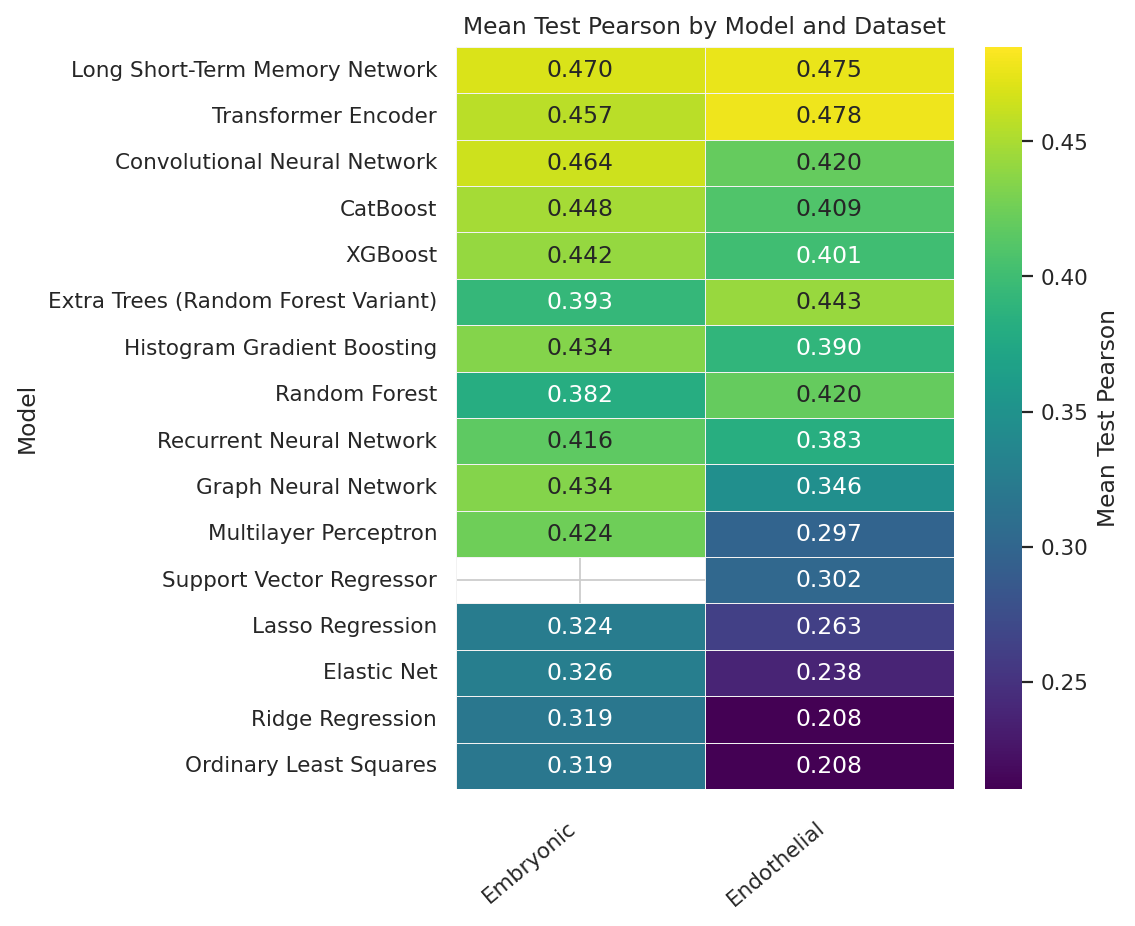

In [26]:
summary_reset = analysis_state["summary_reset"].copy()


def _assign_dataset(run_name: str) -> Optional[str]:
    name = str(run_name).lower()
    if "embryonic" in name:
        return "Embryonic"
    if "endothelial" in name:
        return "Endothelial"
    return None

summary_reset["dataset"] = summary_reset["run_name"].map(_assign_dataset)
subset = summary_reset[summary_reset["dataset"].isin(["Embryonic", "Endothelial"])].copy()
fig_heatmap = None
if subset.empty or "test_pearson_mean" not in subset:
    print("Dataset-specific test Pearson summaries unavailable; skipping heatmap.")
else:
    ranked = subset.sort_values("test_pearson_mean", ascending=False)
    best_per_model = ranked.drop_duplicates(["dataset", "model_id"])
    heatmap_df = best_per_model.pivot_table(
        index="model_display",
        columns="dataset",
        values="test_pearson_mean",
    )
    if heatmap_df.empty:
        print("No values available for dataset heatmap.")
    else:
        order = heatmap_df.mean(axis=1).sort_values(ascending=False).index
        heatmap_df = heatmap_df.loc[order]
        column_order = [col for col in ["Embryonic", "Endothelial"] if col in heatmap_df.columns]
        heatmap_df = heatmap_df[column_order]
        vmin, vmax = compute_heatmap_limits(heatmap_df.values)
        fig_height = max(4, 0.4 * len(heatmap_df))
        fig_width = max(7, 2.0 * len(column_order))
        fig_heatmap, ax = plt.subplots(figsize=(fig_width, fig_height))
        sns.heatmap(
            heatmap_df,
            cmap="viridis",
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt=".3f",
            linewidths=0.4,
            linecolor="#f2f2f2",
            cbar_kws={"label": "Mean Test Pearson"},
            ax=ax,
        )
        ax.set_title("Mean Test Pearson by Model and Dataset")
        ax.set_xlabel("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
        ax.tick_params(axis="x", pad=8)
        ax.set_ylabel("Model")
        sns.despine(fig_heatmap, left=True, bottom=True)
        plt.tight_layout()
        fig_heatmap.subplots_adjust(bottom=0.22)

register_figure(FIGURES, "test_pearson_heatmap_by_dataset", fig_heatmap)
if fig_heatmap is not None:
    display(fig_heatmap)
    plt.close(fig_heatmap)


## 8. Violin Plot: Test Pearson by Dataset


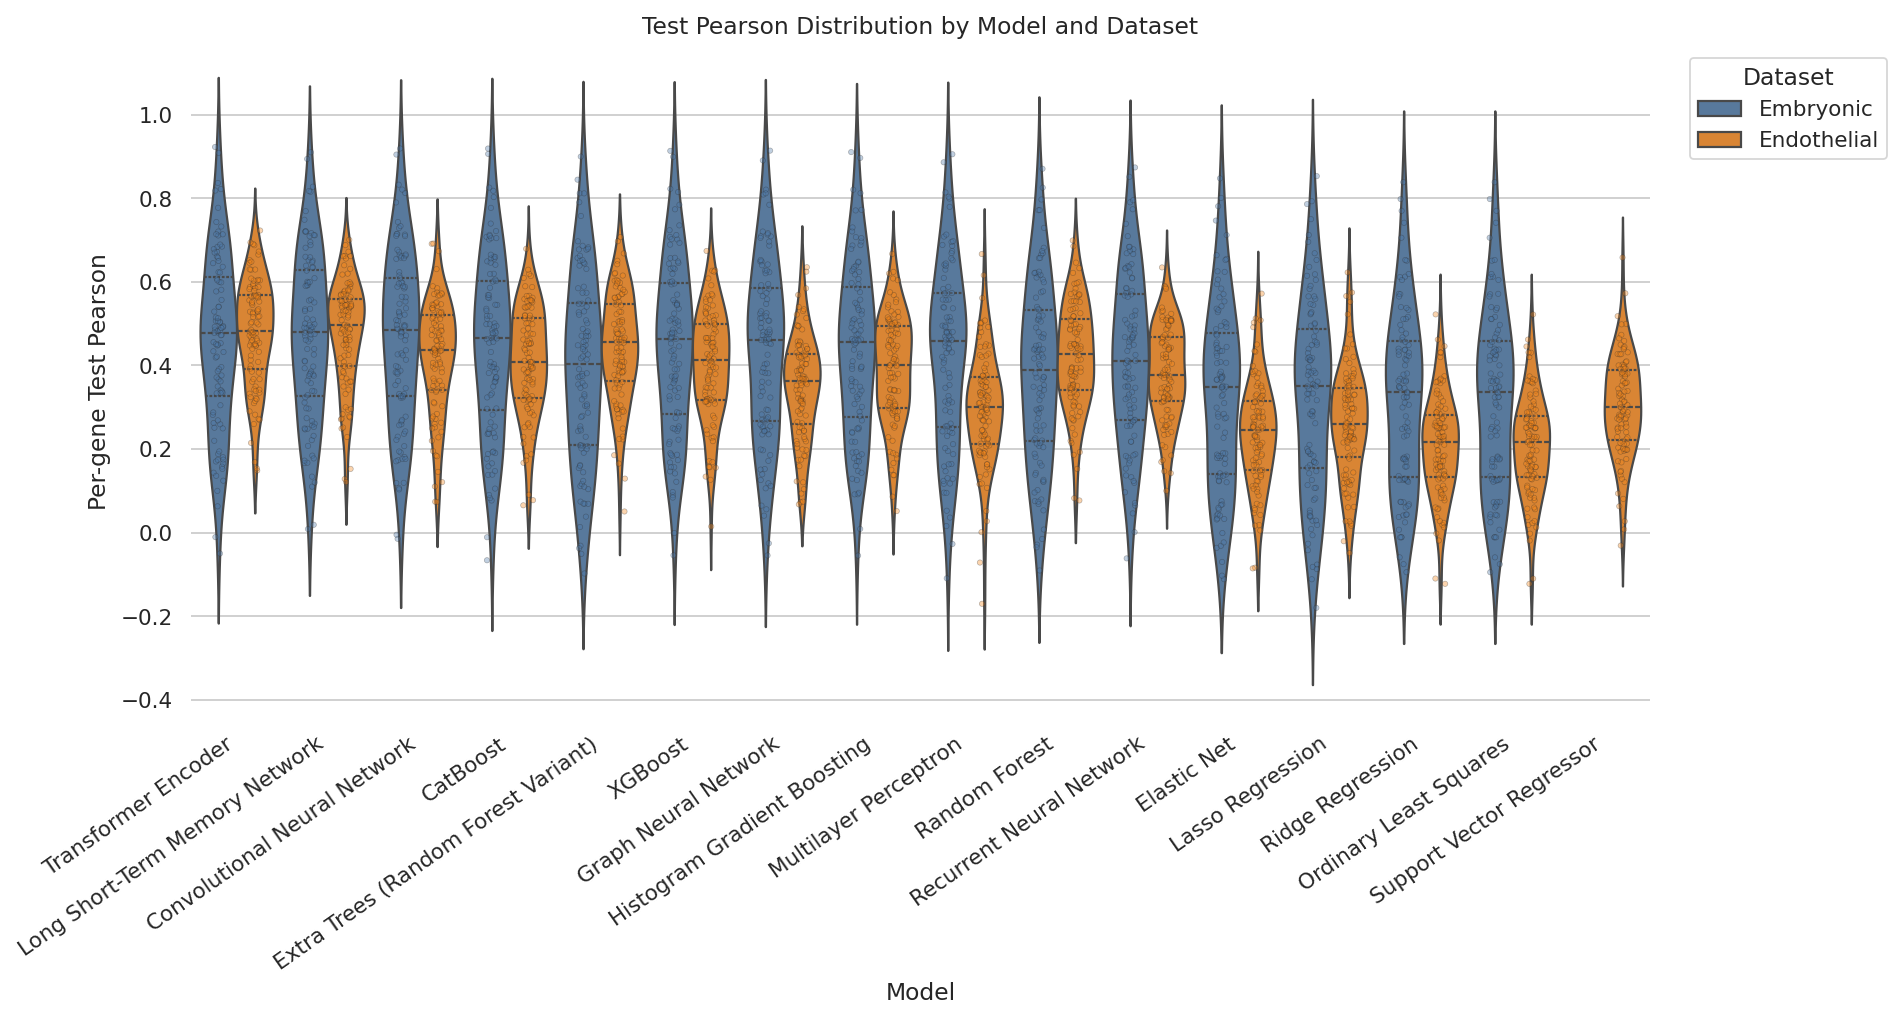

In [27]:
metrics_long = analysis_state["metrics_long"].copy()
model_display_order = analysis_state["model_display_order"]
metrics_long["dataset"] = metrics_long["run_name"].map(_assign_dataset)

subset = metrics_long[
    (metrics_long["split"] == config.primary_split)
    & (metrics_long["dataset"].isin(["Embryonic", "Endothelial"]))
].copy()

fig_violin_by_dataset = None
if subset.empty:
    print("Test metrics unavailable for embryonic/endothelial comparison.")
else:
    ordered_models = [m for m in model_display_order if m in subset["model_display"].unique()]
    if not ordered_models:
        ordered_models = subset["model_display"].sort_values().unique().tolist()
    dataset_order = ["Embryonic", "Endothelial"]
    palette = {"Embryonic": "#4C78A8", "Endothelial": "#F58518"}
    fig_width = max(10, 0.75 * max(6, len(ordered_models)))
    fig_violin_by_dataset, ax = plt.subplots(figsize=(fig_width, 6.5))
    sns.violinplot(
        data=subset,
        x="model_display",
        y="pearson",
        hue="dataset",
        order=ordered_models,
        hue_order=dataset_order,
        palette=palette,
        density_norm="width",
        inner="quartile",
        linewidth=1.0,
        dodge=True,
        ax=ax,
    )
    jitter_sample = subset.sample(
        min(len(subset), 4000),
        random_state=config.random_seed,
    ) if len(subset) > 4000 else subset
    sns.stripplot(
        data=jitter_sample,
        x="model_display",
        y="pearson",
        hue="dataset",
        order=ordered_models,
        hue_order=dataset_order,
        palette=palette,
        dodge=True,
        jitter=0.12,
        size=2.4,
        alpha=0.35,
        edgecolor="#2b2b2b",
        linewidth=0.3,
        marker="o",
        ax=ax,
        legend=False,
    )
    ax.set_title("Test Pearson Distribution by Model and Dataset")
    ax.set_xlabel("Model")
    ax.set_ylabel("Per-gene Test Pearson")
    plt.setp(ax.get_xticklabels(), rotation=35, ha="right")
    ax.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left")
    sns.despine(fig_violin_by_dataset, left=True, bottom=True)
    fig_violin_by_dataset.tight_layout()

register_figure(FIGURES, "test_violin_by_dataset", fig_violin_by_dataset)
if fig_violin_by_dataset is not None:
    display(fig_violin_by_dataset)
    plt.close(fig_violin_by_dataset)


## 9. Generalization Gap by Dataset


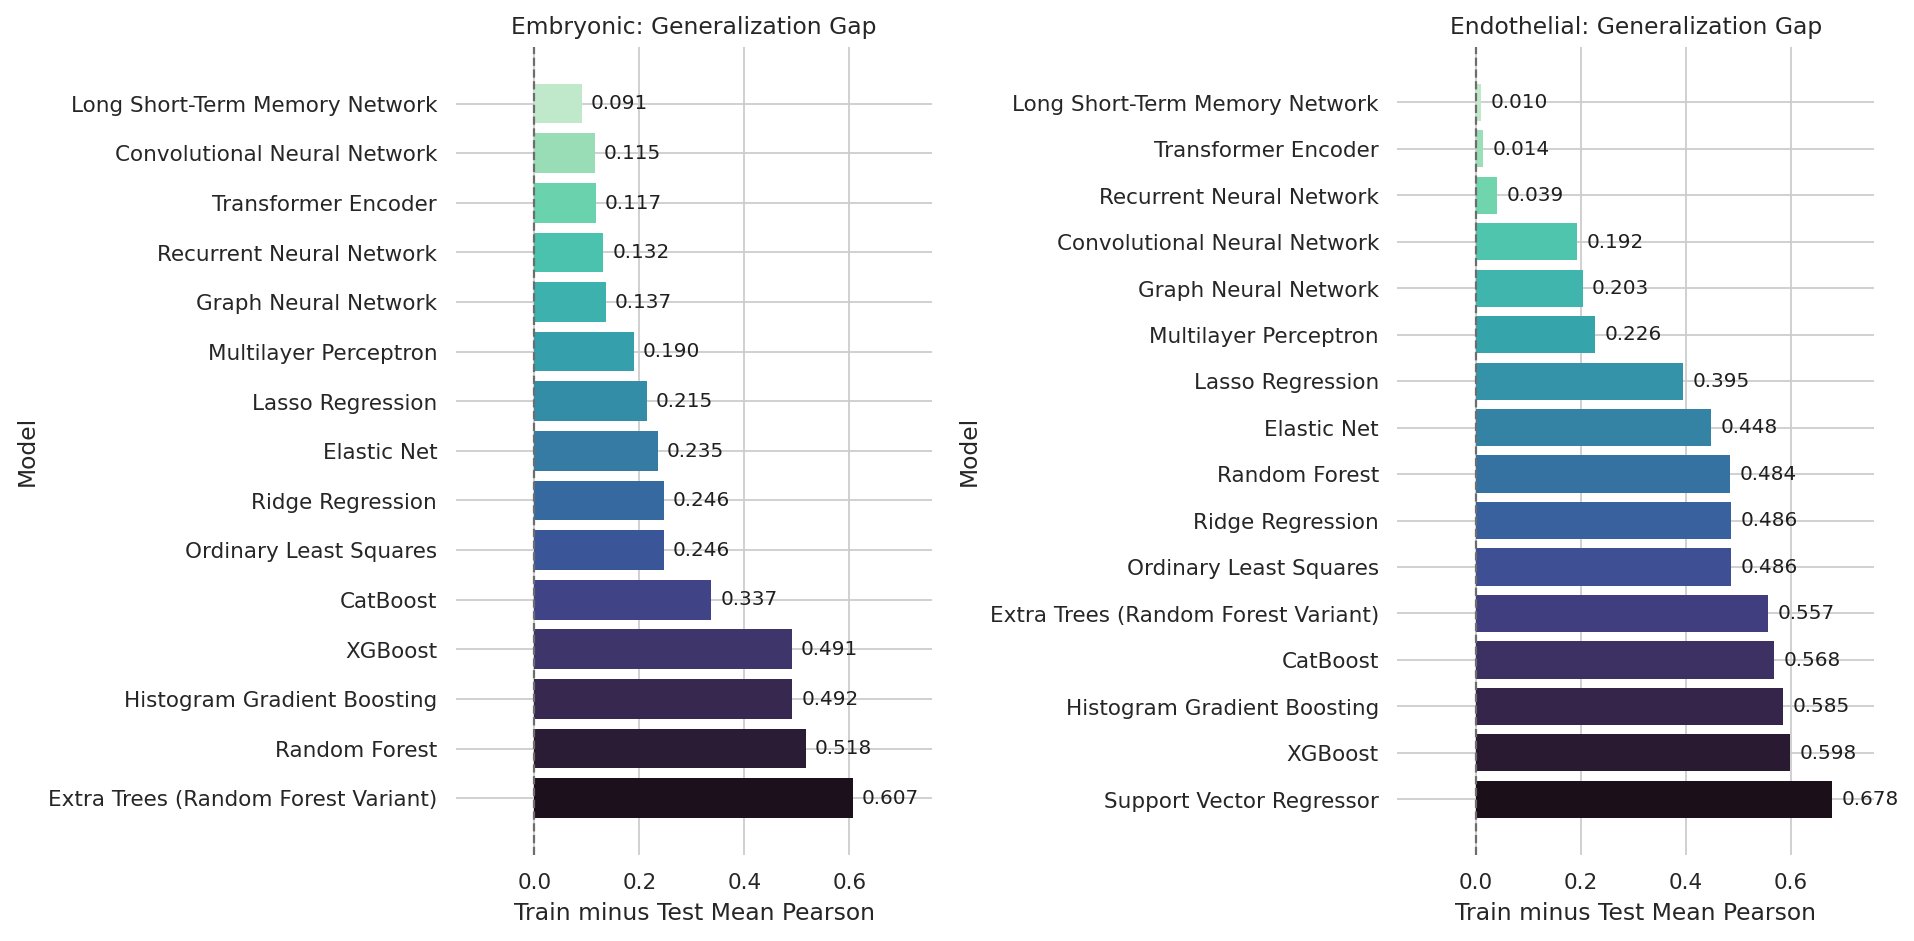

In [28]:
summary_reset = analysis_state["summary_reset"].copy()
summary_reset["dataset"] = summary_reset["run_name"].map(_assign_dataset)

fig_gap = None
required_cols = {"train_pearson_mean", "test_pearson_mean"}
subset = summary_reset[summary_reset["dataset"].isin(["Embryonic", "Endothelial"])].copy()
if subset.empty or not required_cols.issubset(subset.columns):
    print("Train/test summary columns unavailable; skipping generalization gap plot.")
else:
    fig_gap, axes = plt.subplots(ncols=2, figsize=(12, 6), sharex=True)
    for ax, dataset in zip(axes, ["Embryonic", "Endothelial"]):
        data = subset[subset["dataset"] == dataset].copy()
        if data.empty:
            ax.axis("off")
            ax.set_title(f"{dataset} (no data)")
            continue
        ranked = data.sort_values("test_pearson_mean", ascending=False)
        best_per_model = ranked.drop_duplicates("model_id")
        gap_df = best_per_model[["model_display", "train_pearson_mean", "test_pearson_mean"]].copy()
        gap_df["generalization_gap"] = gap_df["train_pearson_mean"] - gap_df["test_pearson_mean"]
        gap_df.sort_values("generalization_gap", ascending=False, inplace=True)
        colors = sns.color_palette("mako", n_colors=len(gap_df))
        bars = ax.barh(
            gap_df["model_display"],
            gap_df["generalization_gap"],
            color=colors,
            linewidth=0,
        )
        ax.axvline(0.0, color="#6d6d6d", linestyle="--", linewidth=1)
        gap_min = gap_df["generalization_gap"].min()
        gap_max = gap_df["generalization_gap"].max()
        span = max(0.01, gap_max - gap_min)
        margin = max(0.08, span * 0.12)
        xmin = min(gap_min - margin, gap_min - 0.02)
        xmin = min(xmin, -0.15)
        xmax = max(gap_max + margin, 0.15)
        ax.set_xlim(xmin, xmax)
        ax.set_xlabel("Train minus Test Mean Pearson")
        ax.set_ylabel("Model")
        ax.set_title(f"{dataset}: Generalization Gap")
        label_offset = (xmax - xmin) * 0.02
        for bar, value in zip(bars, gap_df["generalization_gap"]):
            y = bar.get_y() + bar.get_height() / 2
            if value >= 0:
                ax.text(value + label_offset, y, f"{value:.3f}", va="center", ha="left", fontsize=9, color="#1f1f1f")
            else:
                ax.text(value - label_offset, y, f"{value:.3f}", va="center", ha="right", fontsize=9, color="#1f1f1f")
        sns.despine(ax=ax, left=True, bottom=True)
    fig_gap.tight_layout()

register_figure(FIGURES, "generalization_gap_by_dataset", fig_gap)
if fig_gap is not None:
    display(fig_gap)
    plt.close(fig_gap)


## 10. Per-gene Pearson by Split and Model


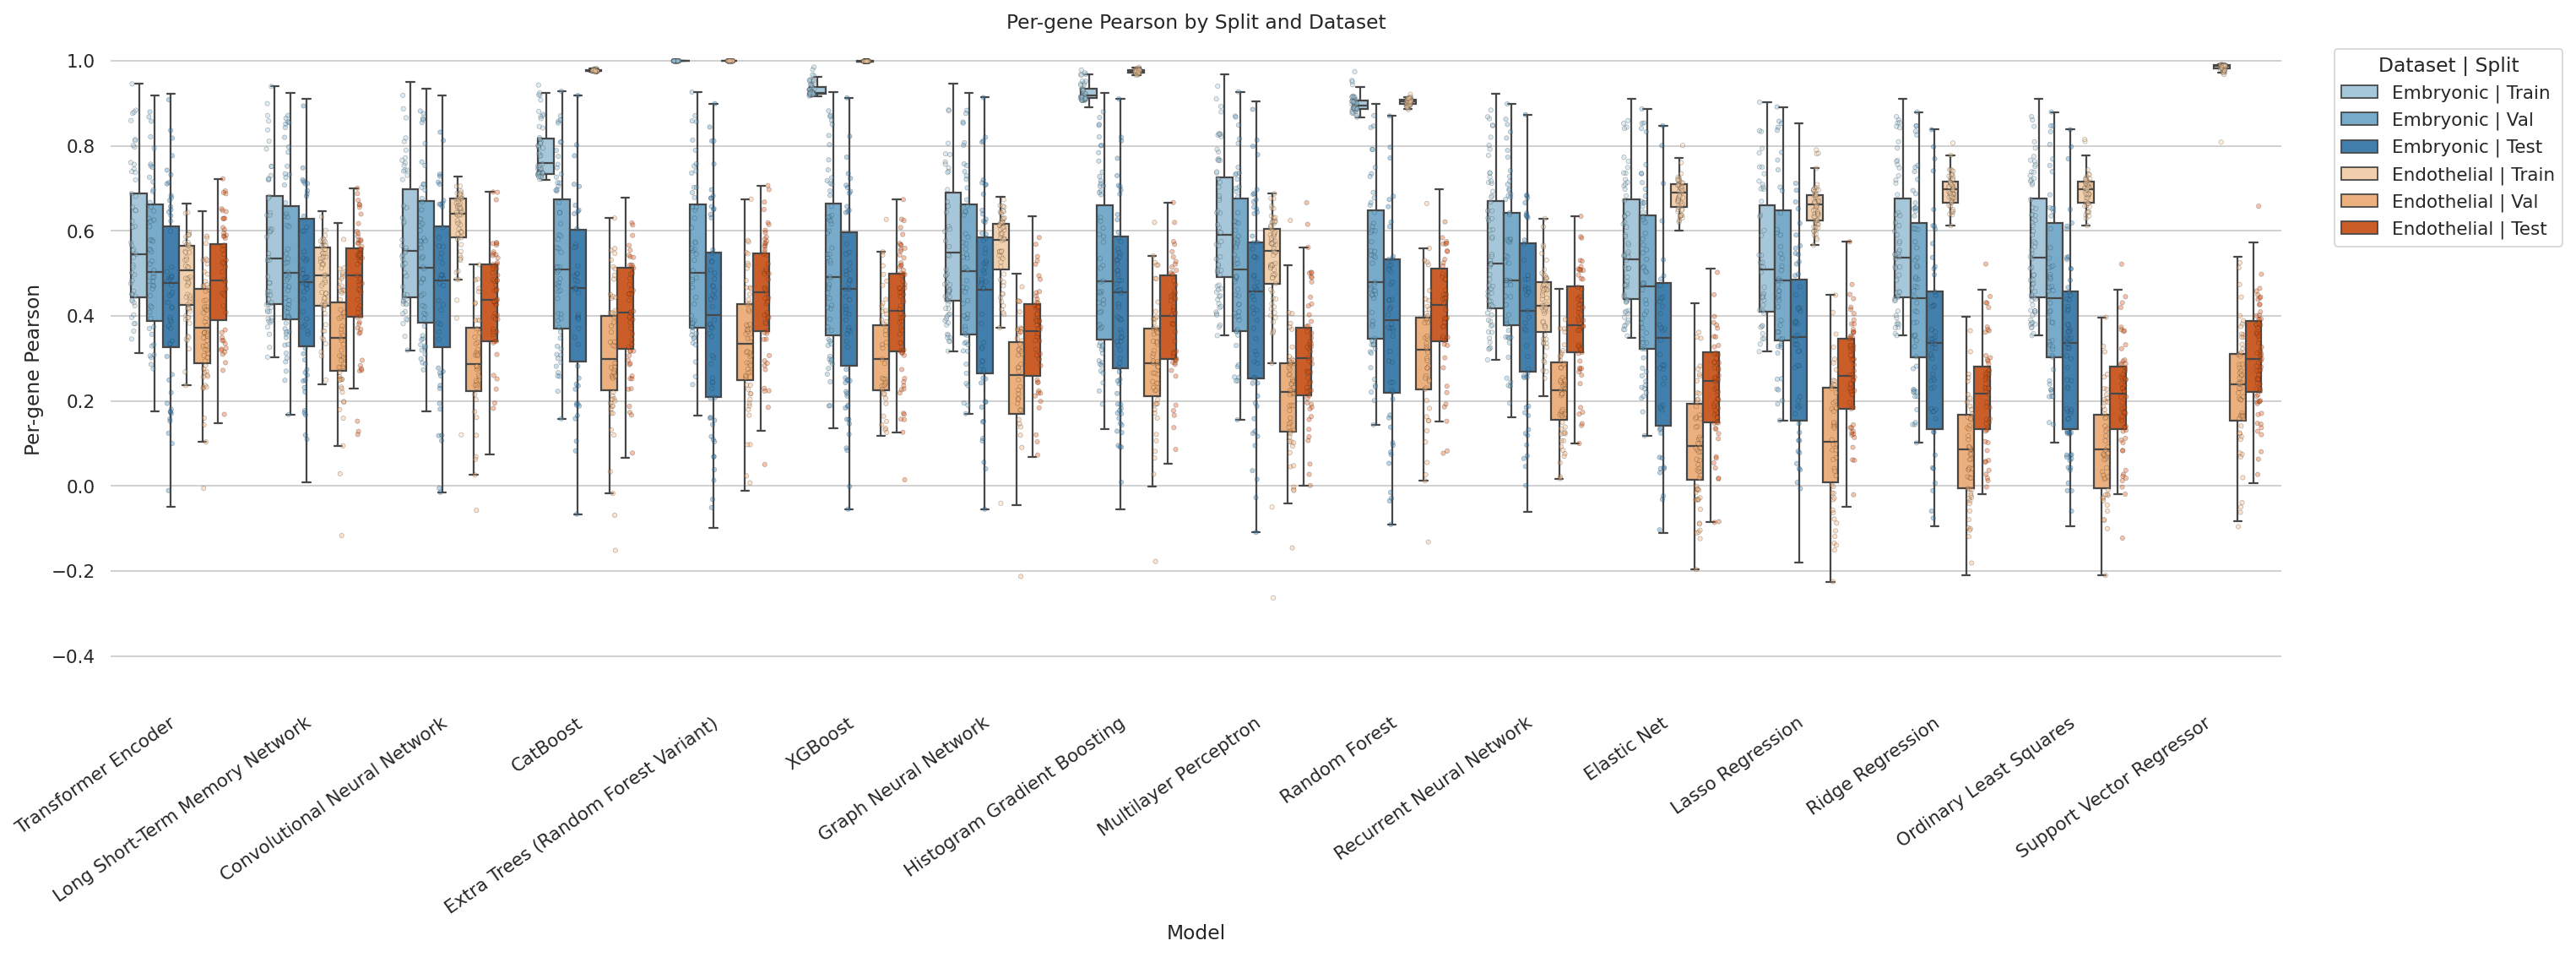

In [29]:
metrics_long = analysis_state["metrics_long"].copy()
metrics_long["dataset"] = metrics_long["run_name"].map(_assign_dataset)
model_display_order = analysis_state["model_display_order"]

splits_of_interest = [config.train_split, config.val_split, config.primary_split]
subset = metrics_long[
    metrics_long["split"].isin(splits_of_interest)
    & metrics_long["dataset"].isin(["Embryonic", "Endothelial"])
].copy()

fig_split_compare = None
if subset.empty or "pearson" not in subset:
    print("Pearson metrics unavailable across requested splits; skipping split comparison plot.")
else:
    subset = subset[["model_display", "split", "pearson", "dataset"]].dropna()
    split_labels = {
        config.train_split: "Train",
        config.val_split: "Val",
        config.primary_split: "Test",
    }
    subset["split_label"] = subset["split"].map(split_labels).fillna(subset["split"].str.title())

    ordered_models = [model for model in model_display_order if model in subset["model_display"].unique()]
    if not ordered_models:
        ordered_models = subset["model_display"].sort_values().unique().tolist()

    # Build 6 hues per model: 3 splits per dataset with shade ramps
    hue_order = [
        "Embryonic | Train",
        "Embryonic | Val",
        "Embryonic | Test",
        "Endothelial | Train",
        "Endothelial | Val",
        "Endothelial | Test",
    ]
    palette = {
        "Embryonic | Train": "#9ecae1",
        "Embryonic | Val": "#6baed6",
        "Embryonic | Test": "#3182bd",
        "Endothelial | Train": "#fdd0a2",
        "Endothelial | Val": "#fdae6b",
        "Endothelial | Test": "#e6550d",
    }
    subset["dataset_split"] = subset["dataset"] + " | " + subset["split_label"]

    fig_width = max(16, 1.2 * max(8, len(ordered_models)))
    fig_split_compare, ax = plt.subplots(figsize=(fig_width, 7.2))
    sns.boxplot(
        data=subset,
        x="model_display",
        y="pearson",
        hue="dataset_split",
        order=ordered_models,
        hue_order=hue_order,
        palette=palette,
        width=0.7,
        fliersize=0,
        ax=ax,
    )
    jitter_sample = subset.sample(min(len(subset), 5000), random_state=config.random_seed) if len(subset) > 5000 else subset
    sns.stripplot(
        data=jitter_sample,
        x="model_display",
        y="pearson",
        hue="dataset_split",
        order=ordered_models,
        hue_order=hue_order,
        palette=palette,
        dodge=True,
        jitter=0.12,
        size=2.4,
        alpha=0.35,
        edgecolor="#2b2b2b",
        linewidth=0.3,
        marker="o",
        ax=ax,
        legend=False,
    )
    metric_min = subset["pearson"].min()
    metric_max = subset["pearson"].max()
    ymin = min(-0.5, metric_min - 0.05)
    ymax = max(1.0, metric_max + 0.05)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Model")
    ax.set_ylabel("Per-gene Pearson")
    ax.set_title("Per-gene Pearson by Split and Dataset")
    plt.setp(ax.get_xticklabels(), rotation=35, ha="right")
    ax.legend(title="Dataset | Split", bbox_to_anchor=(1.02, 1), loc="upper left")
    sns.despine(fig_split_compare, left=True, bottom=True)
    fig_split_compare.tight_layout()

register_figure(FIGURES, "split_comparison_by_dataset", fig_split_compare)
if fig_split_compare is not None:
    display(fig_split_compare)
    plt.close(fig_split_compare)


## 11. Best Model Diagnostics per Dataset


**Embryonic best model:** `Long Short-Term Memory Network` (run `grn_100genes_embryonic_compute_20260102_122245_lstm`)

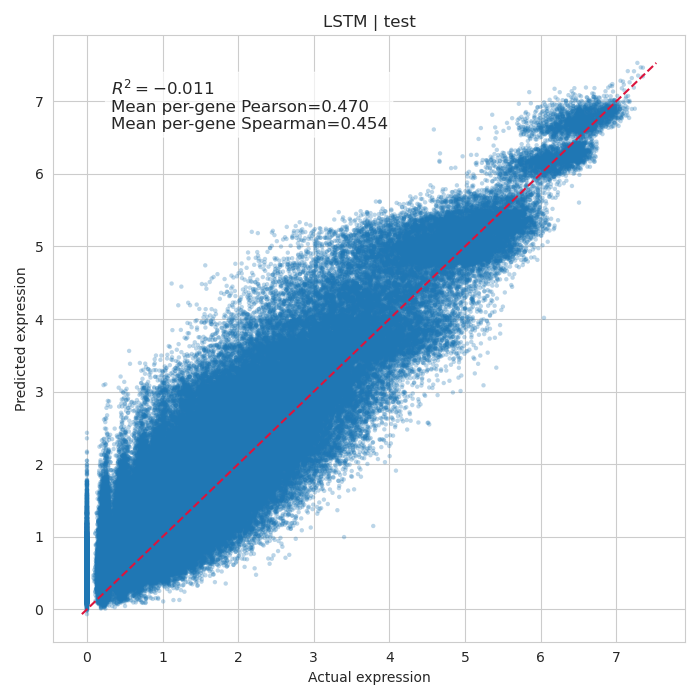

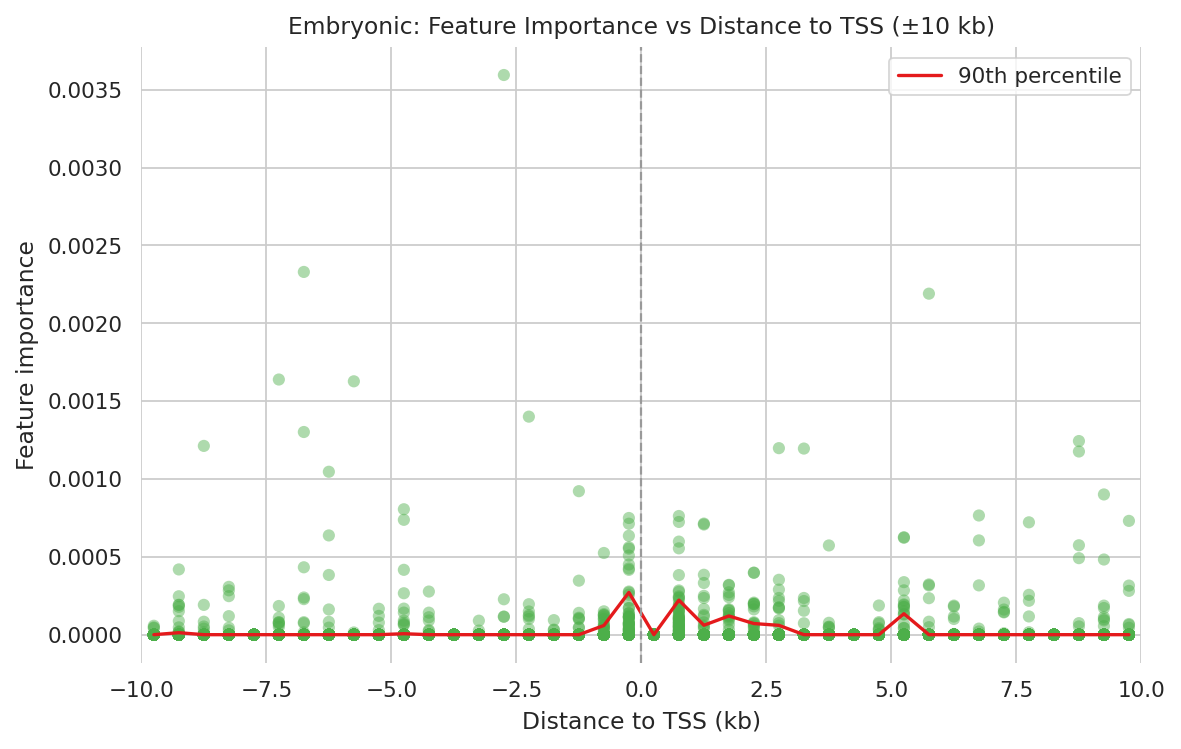

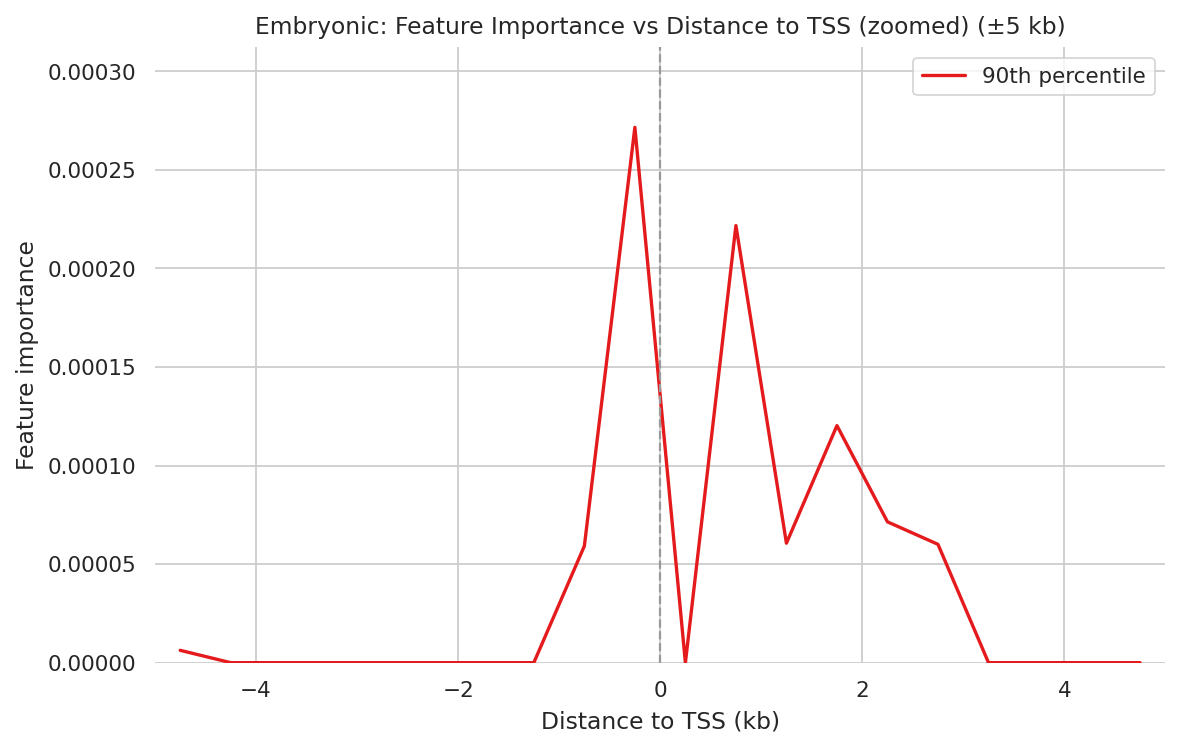

**Endothelial best model:** `Transformer Encoder` (run `grn_100genes_endothelial_compute_20260102_122246_transformer`)

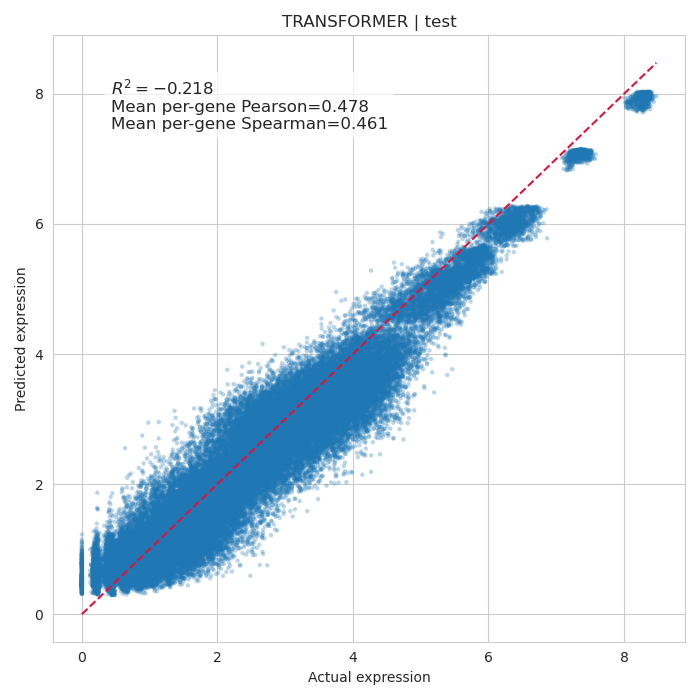

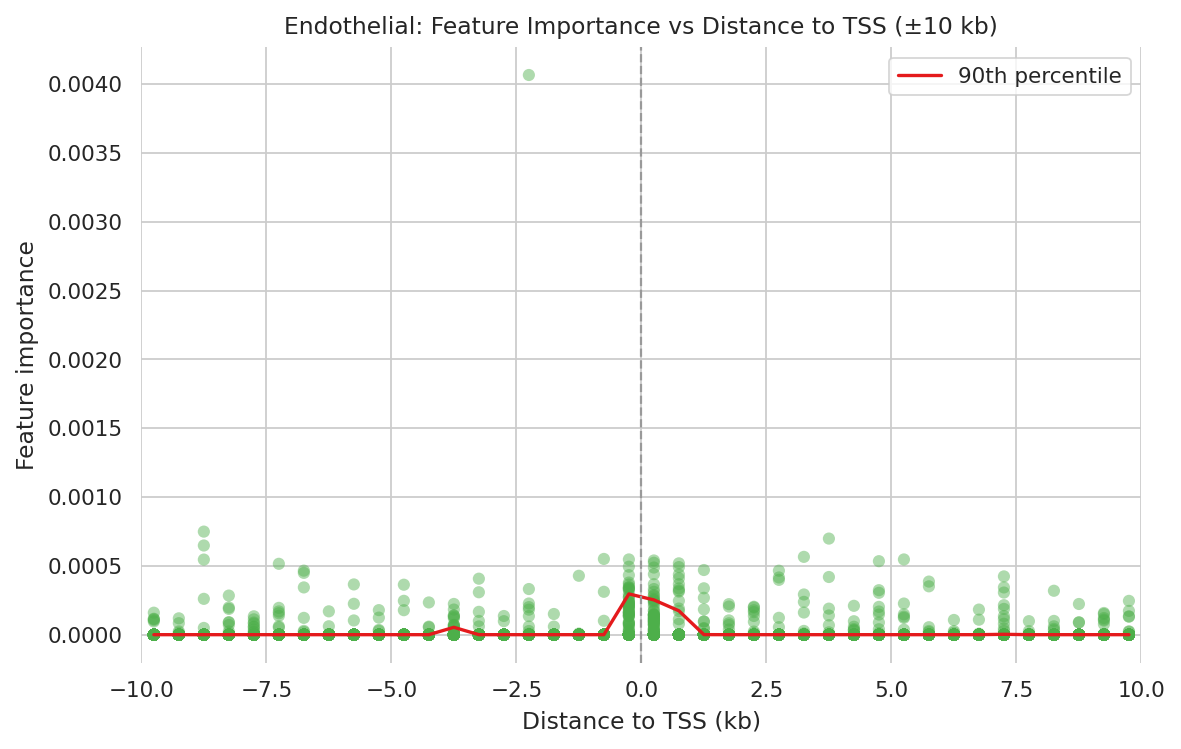

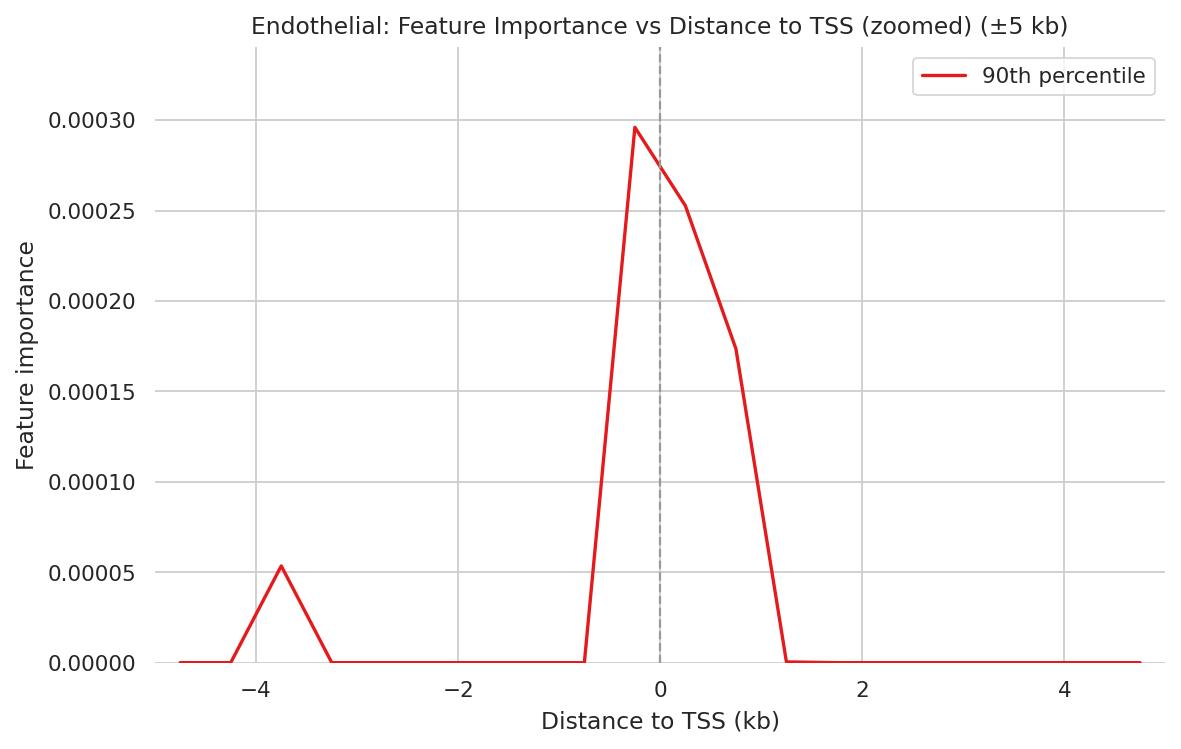

In [30]:
def _load_feature_importance_table(model_dir: Path) -> tuple[pd.DataFrame, Optional[Path]]:
    # Locate and standardise feature importances exported by the training pipeline.
    patterns = [
        "feature_importance*.csv",
        "feature_importances*.csv",
        "feature_importance*.tsv",
        "feature_importances*.tsv",
        "feature_importance*.parquet",
        "feature_importances*.parquet",
    ]
    candidates: list[Path] = []
    for pattern in patterns:
        candidates.extend(model_dir.glob(pattern))
    if not candidates:
        for pattern in patterns:
            candidates.extend(model_dir.glob(f"**/{pattern}"))
    unique_candidates: list[Path] = []
    seen: set[Path] = set()
    for path in candidates:
        resolved = path.resolve()
        if resolved in seen:
            continue
        if resolved.suffix.lower() in {".png", ".jpg", ".jpeg"}:
            continue
        seen.add(resolved)
        unique_candidates.append(resolved)
    for candidate in sorted(unique_candidates):
        try:
            if candidate.suffix.lower() == ".parquet":
                df = pd.read_parquet(candidate)
            else:
                sep = "	" if candidate.suffix.lower() in {".tsv", ".txt"} else ","
                df = pd.read_csv(candidate, sep=sep)
        except Exception as exc:
            print(f"Skipping {candidate.name}: failed to load ({exc})")
            continue
        if df.empty:
            continue
        lower_cols = {col.lower(): col for col in df.columns}
        feature_col = next((
            lower_cols[key]
            for key in ("feature", "feature_name", "name", "variable", "feature_id", "column")
            if key in lower_cols
        ), None)
        importance_col = next((
            lower_cols[key]
            for key in (
                "importance",
                "importance_score",
                "importance_mean",
                "score",
                "value",
                "gain",
                "weight",
            )
            if key in lower_cols
        ), None)
        if feature_col is None or importance_col is None:
            continue
        out = df.copy()
        out.rename(columns={feature_col: "feature", importance_col: "importance"}, inplace=True)
        out["feature"] = out["feature"].astype(str)
        out["importance"] = pd.to_numeric(out["importance"], errors="coerce")
        out = out.dropna(subset=["feature", "importance"])
        if out.empty:
            continue
        extra_cols = [col for col in out.columns if col not in {"feature", "importance"}]
        out = out[["feature", "importance", *extra_cols]]
        out.sort_values("importance", ascending=False, inplace=True)
        return out.reset_index(drop=True), candidate
    return pd.DataFrame(columns=["feature", "importance"]), None


def _best_model_for_dataset(summary_reset: pd.DataFrame, dataset: str) -> Optional[pd.Series]:
    subset = summary_reset[summary_reset["dataset"] == dataset].copy()
    if subset.empty:
        return None
    if "test_pearson_mean" in subset:
        subset.sort_values("test_pearson_mean", ascending=False, inplace=True)
    return subset.iloc[0]


def _ensure_distance_column(df: pd.DataFrame) -> tuple[pd.DataFrame, Optional[str], bool]:
    if df is None or df.empty:
        return df, None, False

    signed_candidates = [
        ("delta_to_tss_kb", True),
        ("distance_to_tss_kb", True),
        ("delta_to_tss_bp", False),
        ("distance_to_tss_bp", False),
    ]
    for name, is_kb in signed_candidates:
        if name in df.columns:
            values = pd.to_numeric(df[name], errors="coerce")
            if (values.dropna() < 0).any():
                return df, name, is_kb

    def _infer_signed_distance(series: pd.Series) -> pd.Series:
        import re
        bin_pattern = re.compile(r"bin_(-?\d+)_to_(-?\d+)")
        def _infer_distance(feature_name: str) -> Optional[float]:
            if not isinstance(feature_name, str):
                return None
            token = feature_name.split("|", 1)[-1]
            match = bin_pattern.search(token)
            if match:
                start_bp = float(match.group(1))
                end_bp = float(match.group(2))
                return 0.5 * (start_bp + end_bp)
            return None
        return series.map(_infer_distance)

    if "feature" in df.columns:
        inferred = _infer_signed_distance(df["feature"])
        if inferred.notna().any():
            df = df.copy()
            df["distance_to_tss_bp_signed"] = inferred
            return df, "distance_to_tss_bp_signed", False

    return df, None, False


def _plot_feature_importance_distance(
    df: pd.DataFrame,
    distance_col: str,
    distance_is_kb: bool,
    title: str,
    *,
    max_distance_kb: float = 10.0,
    y_limits: Optional[tuple[float, float]] = None,
    show_scatter: bool = False,
) -> Optional[plt.Figure]:
    if df is None or df.empty or distance_col is None:
        return None
    valid = df.dropna(subset=["importance", distance_col]).copy()
    if valid.empty:
        return None
    distance_values = pd.to_numeric(valid[distance_col], errors="coerce")
    valid["distance_kb"] = distance_values if distance_is_kb else distance_values / 1_000.0
    valid = valid[valid["distance_kb"].abs() <= max_distance_kb].copy()
    if valid.empty:
        return None
    if not (valid["distance_kb"] < 0).any():
        print("Warning: no negative distance-to-TSS values detected; data may be absolute distances.")
    valid.sort_values("distance_kb", inplace=True)

    per_bin = (
        valid.groupby("distance_kb", sort=True)["importance"]
        .quantile(0.9)
        .reset_index()
    )
    if per_bin.empty:
        return None

    fig, ax = plt.subplots(figsize=(7.5, 4.8))
    if show_scatter:
        sns.scatterplot(
            data=valid,
            x="distance_kb",
            y="importance",
            s=30,
            alpha=0.45,
            edgecolor="none",
            color="#4daf4a",
            ax=ax,
        )
    ax.plot(
        per_bin["distance_kb"],
        per_bin["importance"],
        color="#e41a1c",
        linewidth=1.5,
        label="90th percentile",
    )
    ax.legend(loc="upper right", frameon=True)
    ax.axvline(0.0, color="#999999", linestyle="--", linewidth=1)
    ax.set_xlim(-max_distance_kb, max_distance_kb)
    if y_limits is not None:
        ax.set_ylim(y_limits)
    ax.set_xlabel("Distance to TSS (kb)")
    ax.set_ylabel("Feature importance")
    ax.set_title(f"{title} (±{max_distance_kb:g} kb)")
    sns.despine(fig, left=True, bottom=True)
    plt.tight_layout()
    return fig


summary_reset = analysis_state["summary_reset"].copy()
summary_reset["dataset"] = summary_reset["run_name"].map(_assign_dataset)
run_df = analysis_state["run_df"]

for dataset in ["Embryonic", "Endothelial"]:
    best_row = _best_model_for_dataset(summary_reset, dataset)
    if best_row is None:
        print(f"No best model found for {dataset}.")
        continue
    run_match = run_df[
        (run_df["run_name"] == best_row["run_name"]) & (run_df["model_id"] == best_row["model_id"])
    ]
    if run_match.empty:
        print(f"Run metadata missing for {dataset} best model.")
        continue
    row = run_match.iloc[0]
    model_dir = row["model_path"] if isinstance(row["model_path"], Path) else Path(row["model_path"])
    scatter_path = model_dir / "scatter_test.png"
    display(Markdown(
        f"**{dataset} best model:** `{best_row['model_display']}` (run `{best_row['run_name']}`)"
    ))
    if scatter_path.exists():
        display(Image(filename=str(scatter_path)))
        EXTRA_EXPORT_PATHS.append((scatter_path, f"{dataset.lower()}_scatter_test.png"))
    else:
        preds_path = row.get("predictions_path")
        preds_path = preds_path if isinstance(preds_path, Path) else Path(preds_path) if preds_path else None
        if preds_path is None or not preds_path.exists():
            print(f"No scatter or prediction file found for {dataset} best model.")
        else:
            df = pd.read_csv(preds_path)
            df = df[df["split"] == config.primary_split]
            if df.empty:
                print(f"No test predictions available for {dataset} best model.")
            else:
                sample = df.sample(min(len(df), 8000), random_state=config.random_seed)
                fig_scatter, ax = plt.subplots(figsize=(5.2, 5.2))
                sns.scatterplot(
                    data=sample,
                    x="y_true",
                    y="y_pred",
                    s=14,
                    alpha=0.4,
                    edgecolor="none",
                    color="#377eb8",
                    ax=ax,
                )
                lims = [
                    min(sample["y_true"].min(), sample["y_pred"].min()),
                    max(sample["y_true"].max(), sample["y_pred"].max()),
                ]
                ax.plot(lims, lims, linestyle="--", color="#6d6d6d", linewidth=1)
                ax.set_xlim(lims)
                ax.set_ylim(lims)
                ax.set_xlabel("Observed")
                ax.set_ylabel("Predicted")
                ax.set_title(f"{dataset}: Test Scatter | {best_row['model_display']}")
                sns.despine(fig_scatter, left=True, bottom=True)
                plt.tight_layout()
                register_figure(FIGURES, f"{dataset.lower()}_best_model_scatter", fig_scatter)
                display(fig_scatter)
                plt.close(fig_scatter)

    importance_df, importance_path = _load_feature_importance_table(model_dir)
    if importance_df.empty:
        print(f"No feature importance table found for {dataset} best model.")
        continue
    importance_df, distance_col, distance_is_kb = _ensure_distance_column(importance_df)
    if distance_col is None or distance_col not in importance_df.columns:
        print(f"Unable to infer distance-to-TSS column for {dataset} best model.")
        continue
    fig_distance = _plot_feature_importance_distance(
        importance_df,
        distance_col,
        distance_is_kb,
        f"{dataset}: Feature Importance vs Distance to TSS",
        max_distance_kb=10.0,
        show_scatter=True,
    )
    zoom_mask = importance_df[distance_col].notna()
    if zoom_mask.any():
        distance_values = pd.to_numeric(importance_df.loc[zoom_mask, distance_col], errors="coerce")
        distance_kb = distance_values if distance_is_kb else distance_values / 1_000.0
        zoom_range = distance_kb.abs() <= 5.0
        zoom_importance = pd.to_numeric(importance_df.loc[zoom_mask, "importance"], errors="coerce")
        zoom_df = pd.DataFrame({"distance_kb": distance_kb[zoom_range], "importance": zoom_importance[zoom_range]})
        if zoom_df.empty:
            zoom_max = None
        else:
            zoom_max = zoom_df.groupby("distance_kb")["importance"].quantile(0.9).max()
        zoom_y_limits = (0.0, float(zoom_max) * 1.15) if pd.notna(zoom_max) else None
    else:
        zoom_y_limits = None
    fig_distance_zoomed = _plot_feature_importance_distance(
        importance_df,
        distance_col,
        distance_is_kb,
        f"{dataset}: Feature Importance vs Distance to TSS (zoomed)",
        max_distance_kb=5.0,
        y_limits=zoom_y_limits,
    )
    if fig_distance is None or fig_distance_zoomed is None:
        print(f"No valid distance/importance data for {dataset} best model.")
    else:
        model_short = MODEL_ID_TO_SHORT.get(best_row['model_id'], best_row['model_display'])
        register_figure(FIGURES, f"{dataset.lower()}_{model_short}_feature_importance_tss", fig_distance)
        display(fig_distance)
        plt.close(fig_distance)
        register_figure(FIGURES, f"{dataset.lower()}_{model_short}_feature_importance_tss_zoomed", fig_distance_zoomed)
        display(fig_distance_zoomed)
        plt.close(fig_distance_zoomed)


## 12. Export Figures

Save all generated matplotlib figures to the manuscript figure directory.


In [31]:
import shutil

project_root = Path(analysis_metadata.get("project_root", config.project_root))
fig_dir_raw = analysis_metadata.get("fig_dir", config.fig_dir)
fig_dir = Path(fig_dir_raw)
if not fig_dir.is_absolute():
    fig_dir = project_root / fig_dir
fig_dir = fig_dir.resolve()
fig_dir.mkdir(parents=True, exist_ok=True)

exported = []
if not FIGURES:
    print("No figures registered for export.")
else:
    for key, fig in FIGURES.items():
        if fig is None:
            continue
        out_path = fig_dir / f"{key}.png"
        fig.savefig(out_path, bbox_inches="tight")
        exported.append(out_path)

if EXTRA_EXPORT_PATHS:
    for src_path, out_name in EXTRA_EXPORT_PATHS:
        src_path = Path(src_path)
        if not src_path.exists():
            continue
        out_path = fig_dir / out_name
        shutil.copy2(src_path, out_path)
        exported.append(out_path)

if not exported:
    print("No figures were exported.")
else:
    print(f"Exported {len(exported)} figures to {fig_dir}")
    for path in exported:
        print(f"- {path}")


Exported 10 figures to /gpfs/Home/tqw5435/uzun/multiomic-ml-grn/analysis/figs/manuscript_100genes
- /gpfs/Home/tqw5435/uzun/multiomic-ml-grn/analysis/figs/manuscript_100genes/test_pearson_heatmap_by_dataset.png
- /gpfs/Home/tqw5435/uzun/multiomic-ml-grn/analysis/figs/manuscript_100genes/test_violin_by_dataset.png
- /gpfs/Home/tqw5435/uzun/multiomic-ml-grn/analysis/figs/manuscript_100genes/generalization_gap_by_dataset.png
- /gpfs/Home/tqw5435/uzun/multiomic-ml-grn/analysis/figs/manuscript_100genes/split_comparison_by_dataset.png
- /gpfs/Home/tqw5435/uzun/multiomic-ml-grn/analysis/figs/manuscript_100genes/embryonic_LSTM_feature_importance_tss.png
- /gpfs/Home/tqw5435/uzun/multiomic-ml-grn/analysis/figs/manuscript_100genes/embryonic_LSTM_feature_importance_tss_zoomed.png
- /gpfs/Home/tqw5435/uzun/multiomic-ml-grn/analysis/figs/manuscript_100genes/endothelial_Transformer_feature_importance_tss.png
- /gpfs/Home/tqw5435/uzun/multiomic-ml-grn/analysis/figs/manuscript_100genes/endothelial_Tra

## Comparison: 100 vs 1000 Gene Runs


In [6]:
# Load summary metrics for 100 and 1000 gene runs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob

# Load data for 100 gene runs (both datasets)
embryonic_100 = pd.read_csv('/gpfs/Home/tqw5435/uzun/multiomic-ml-grn/analysis/reports/embryonic_100genes/summary_metrics_all_models.csv')
embryonic_100['dataset'] = 'Embryonic'
embryonic_100['n_genes'] = '100'

endothelial_100 = pd.read_csv('/gpfs/Home/tqw5435/uzun/multiomic-ml-grn/analysis/reports/endothelial_100genes/summary_metrics_all_models.csv')
endothelial_100['dataset'] = 'Endothelial'
endothelial_100['n_genes'] = '100'

# Load data for 1000 gene runs - need to find the individual run metrics
# Check for individual run directories
results_base = '/gpfs/Home/tqw5435/uzun/multiomic-ml-grn/output/results/grn_regression_cellwise'

# Function to load metrics from individual runs
def load_1000gene_runs(dataset_name):
    """Load all 1000 gene runs for a specific dataset"""
    pattern = f"{results_base}/grn_1000genes_{dataset_name.lower()}_*"
    run_dirs = glob.glob(pattern)
    
    all_metrics = []
    for run_dir in run_dirs:
        models_dir = f"{run_dir}/models"
        if not os.path.exists(models_dir):
            continue
        
        # Look for model subdirectories
        for model_dir in glob.glob(f"{models_dir}/*"):
            if not os.path.isdir(model_dir):
                continue
            
            metrics_file = f"{model_dir}/metrics_per_gene.csv"
            if os.path.exists(metrics_file):
                try:
                    df = pd.read_csv(metrics_file)
                    model_id = os.path.basename(model_dir)
                    run_name = os.path.basename(run_dir)
                    
                    # Calculate summary statistics
                    for split in ['test', 'val', 'train']:
                        split_data = df[df['split'] == split]
                        if len(split_data) > 0:
                            all_metrics.append({
                                'model_id': model_id,
                                'run_name': run_name,
                                'split': split,
                                'pearson_mean': split_data['pearson'].mean(),
                                'pearson_std': split_data['pearson'].std()
                            })
                except Exception as e:
                    print(f"Error loading {metrics_file}: {e}")
    
    if not all_metrics:
        return pd.DataFrame()
    
    # Pivot to get one row per model
    df = pd.DataFrame(all_metrics)
    summary = df.pivot_table(
        index=['model_id', 'run_name'],
        columns='split',
        values=['pearson_mean', 'pearson_std']
    )
    summary.columns = [f'{split}_{metric}' for metric, split in summary.columns]
    summary = summary.reset_index()
    
    return summary

# Load 1000 gene data for both datasets
embryonic_1000 = load_1000gene_runs('embryonic')
endothelial_1000 = load_1000gene_runs('endothelial')

print(f"Loaded {len(embryonic_1000)} embryonic 1000-gene runs")
print(f"Loaded {len(endothelial_1000)} endothelial 1000-gene runs")

# Add dataset and gene count columns
if not embryonic_1000.empty:
    embryonic_1000['dataset'] = 'Embryonic'
    embryonic_1000['n_genes'] = '1000'
    
if not endothelial_1000.empty:
    endothelial_1000['dataset'] = 'Endothelial'
    endothelial_1000['n_genes'] = '1000'

# Standardize column names to match the 100-gene format
for df in [embryonic_1000, endothelial_1000]:
    if not df.empty and 'pearson_mean_test' in df.columns:
        df.rename(columns={
            'pearson_mean_test': 'test_pearson_mean',
            'pearson_std_test': 'test_pearson_std',
            'pearson_mean_val': 'val_pearson_mean',
            'pearson_std_val': 'val_pearson_std',
            'pearson_mean_train': 'train_pearson_mean',
            'pearson_std_train': 'train_pearson_std'
        }, inplace=True)

# Add model_display names
from pathlib import Path
import sys
sys.path.insert(0, str(Path.cwd().parent / 'src'))

model_lookup = pd.read_csv('/gpfs/Home/tqw5435/uzun/multiomic-ml-grn/analysis/model_name_lookup.tsv', sep='\t')
id_to_display = dict(zip(model_lookup['model_id'], model_lookup['model_display_name']))

for df in [embryonic_1000, endothelial_1000]:
    if not df.empty:
        df['model_display'] = df['model_id'].map(id_to_display).fillna(df['model_id'])

# Combine all data
df_combined = pd.concat([embryonic_100, endothelial_100, embryonic_1000, endothelial_1000], ignore_index=True)

# Display summary
print(f"\nTotal records: {len(df_combined)}")
print(f"\nBreakdown by dataset and n_genes:")
print(df_combined.groupby(['dataset', 'n_genes']).size())

df_combined.head()

Loaded 9 embryonic 1000-gene runs
Loaded 11 endothelial 1000-gene runs

Total records: 51

Breakdown by dataset and n_genes:
dataset      n_genes
Embryonic    100        15
             1000        9
Endothelial  100        16
             1000       11
dtype: int64


,model_display,model_id,run_name,test_pearson_mean,test_pearson_std,val_pearson_mean,val_pearson_std,train_pearson_mean,train_pearson_std,dataset,n_genes
0,Long Short-Term Memory Network,lstm,grn_100genes_embryonic_compute_20260102_122245...,0.469571,0.199335,0.532508,0.179144,0.560266,0.160660,Embryonic,100
1,Convolutional Neural Network,cnn,grn_100genes_embryonic_compute_20260102_122245...,0.464458,0.206525,0.540026,0.183492,0.579186,0.159365,Embryonic,100
2,Transformer Encoder,transformer,grn_100genes_embryonic_compute_20260102_122245...,0.456822,0.209120,0.535763,0.179412,0.573904,0.159066,Embryonic,100
3,CatBoost,catboost,grn_100genes_embryonic_compute_20260102_122245...,0.447831,0.211061,0.532701,0.187693,0.785309,0.062702,Embryonic,100
4,XGBoost,xgboost,grn_100genes_embryonic_compute_20260102_122245...,0.441642,0.207938,0.519722,0.193643,0.932574,0.015670,Embryonic,100


In [7]:
# Create comparison figure: 100 vs 1000 genes
# Group by model and calculate differences

# First, let's create a pivot to compare
comparison_data = []

for model in df_combined['model_display'].unique():
    model_data = df_combined[df_combined['model_display'] == model]
    
    for dataset in ['Embryonic', 'Endothelial']:
        data_100 = model_data[(model_data['dataset'] == dataset) & (model_data['n_genes'] == '100')]
        data_1000 = model_data[(model_data['dataset'] == dataset) & (model_data['n_genes'] == '1000')]
        
        if len(data_100) > 0:
            pearson_100 = data_100['test_pearson_mean'].values[0]
        else:
            pearson_100 = None
            
        if len(data_1000) > 0:
            pearson_1000 = data_1000['test_pearson_mean'].values[0]
        else:
            pearson_1000 = None
        
        comparison_data.append({
            'model': model,
            'dataset': dataset,
            'pearson_100': pearson_100,
            'pearson_1000': pearson_1000,
            'difference': pearson_1000 - pearson_100 if (pearson_100 is not None and pearson_1000 is not None) else None
        })

df_comparison = pd.DataFrame(comparison_data)

# Display the comparison table
print("Comparison of Test Pearson by Model and Dataset (100 vs 1000 genes):")
print("="*80)
df_comparison_display = df_comparison.copy()
df_comparison_display = df_comparison_display.sort_values(['dataset', 'pearson_1000'], ascending=[True, False])
print(df_comparison_display.to_string(index=False))
print("\n")

# Calculate summary statistics
print("Summary Statistics:")
print("-"*80)
for dataset in ['Embryonic', 'Endothelial']:
    dataset_data = df_comparison[df_comparison['dataset'] == dataset]
    valid_diffs = dataset_data['difference'].dropna()
    if len(valid_diffs) > 0:
        print(f"\n{dataset}:")
        print(f"  Mean difference (1000 - 100): {valid_diffs.mean():.4f}")
        print(f"  Median difference: {valid_diffs.median():.4f}")
        print(f"  Models with improvement: {(valid_diffs > 0).sum()}/{len(valid_diffs)}")
        print(f"  Models with decline: {(valid_diffs < 0).sum()}/{len(valid_diffs)}")

Comparison of Test Pearson by Model and Dataset (100 vs 1000 genes):
                              model     dataset  pearson_100  pearson_1000  difference
              Multilayer Perceptron   Embryonic     0.423979      0.558927    0.134948
       Convolutional Neural Network   Embryonic     0.464458      0.549439    0.084981
               Graph Neural Network   Embryonic     0.434346      0.546439    0.112093
     Long Short-Term Memory Network   Embryonic     0.469571      0.526398    0.056826
                Transformer Encoder   Embryonic     0.456822      0.522597    0.065776
           Recurrent Neural Network   Embryonic     0.416289      0.490112    0.073824
Extra Trees (Random Forest Variant)   Embryonic     0.393291      0.442251    0.048960
             Ordinary Least Squares   Embryonic     0.318698      0.393048    0.074350
                   Ridge Regression   Embryonic     0.318700      0.392984    0.074283
                           CatBoost   Embryonic     0.447831 

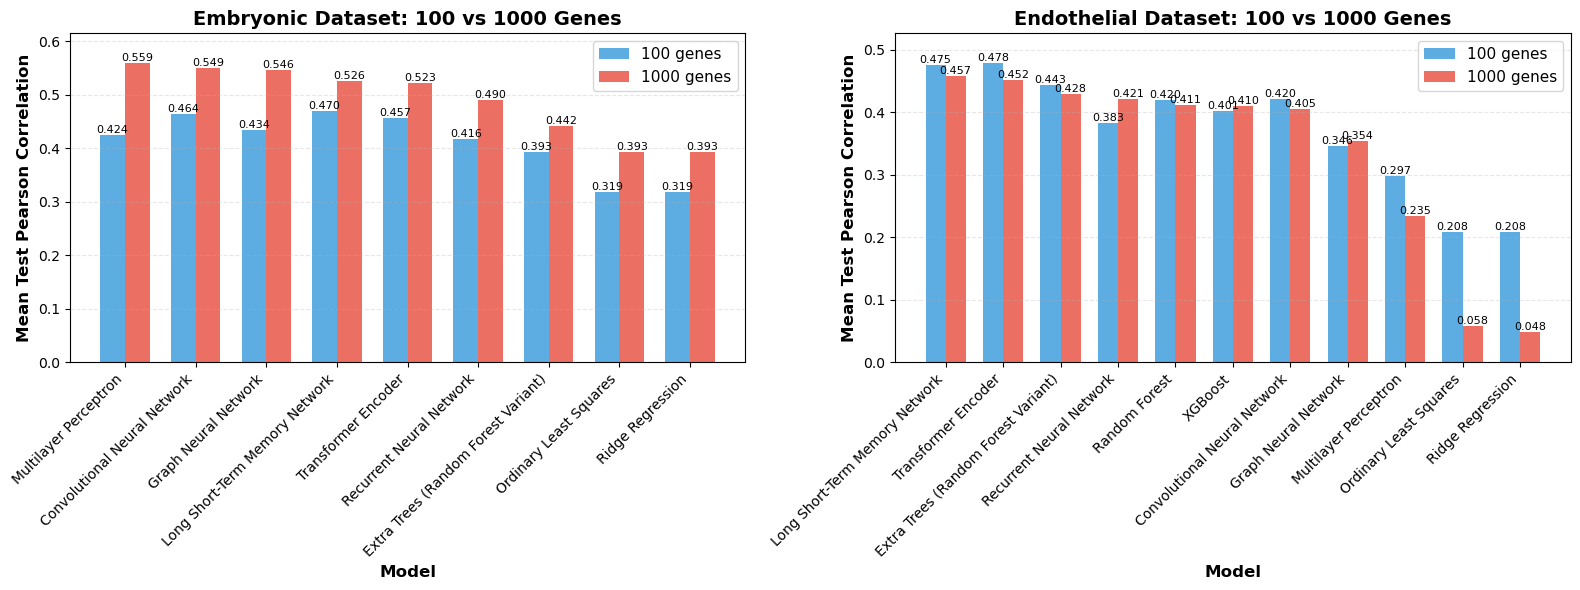

In [9]:
# Create the comparison figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Filter to only models that have both 100 and 1000 gene data for each dataset
embryonic_comp = df_comparison[(df_comparison['dataset'] == 'Embryonic') & 
                                (df_comparison['pearson_100'].notna()) & 
                                (df_comparison['pearson_1000'].notna())]

endothelial_comp = df_comparison[(df_comparison['dataset'] == 'Endothelial') & 
                                  (df_comparison['pearson_100'].notna()) &
                                  (df_comparison['pearson_1000'].notna())]

# Plot 1: Embryonic dataset comparison
ax = axes[0]
x_pos = np.arange(len(embryonic_comp))
width = 0.35

models_embryonic = embryonic_comp.sort_values('pearson_1000', ascending=False)['model'].values
pearson_100_embryonic = embryonic_comp.sort_values('pearson_1000', ascending=False)['pearson_100'].values
pearson_1000_embryonic = embryonic_comp.sort_values('pearson_1000', ascending=False)['pearson_1000'].values

bars1 = ax.bar(x_pos - width/2, pearson_100_embryonic, width, label='100 genes', alpha=0.8, color='#3498db')
bars2 = ax.bar(x_pos + width/2, pearson_1000_embryonic, width, label='1000 genes', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Test Pearson Correlation', fontsize=12, fontweight='bold')
ax.set_title('Embryonic Dataset: 100 vs 1000 Genes', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(models_embryonic, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(pearson_1000_embryonic.max(), pearson_100_embryonic.max()) * 1.1)

# Add value labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1,
            f'{height1:.3f}', ha='center', va='bottom', fontsize=8)
    ax.text(bar2.get_x() + bar2.get_width()/2., height2,
            f'{height2:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Endothelial dataset comparison
ax = axes[1]

if len(endothelial_comp) > 0:
    x_pos_endo = np.arange(len(endothelial_comp))
    
    models_endothelial = endothelial_comp.sort_values('pearson_1000', ascending=False)['model'].values
    pearson_100_endothelial = endothelial_comp.sort_values('pearson_1000', ascending=False)['pearson_100'].values
    pearson_1000_endothelial = endothelial_comp.sort_values('pearson_1000', ascending=False)['pearson_1000'].values
    
    bars3 = ax.bar(x_pos_endo - width/2, pearson_100_endothelial, width, label='100 genes', alpha=0.8, color='#3498db')
    bars4 = ax.bar(x_pos_endo + width/2, pearson_1000_endothelial, width, label='1000 genes', alpha=0.8, color='#e74c3c')
    
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Test Pearson Correlation', fontsize=12, fontweight='bold')
    ax.set_title('Endothelial Dataset: 100 vs 1000 Genes', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos_endo)
    ax.set_xticklabels(models_endothelial, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, max(pearson_1000_endothelial.max(), pearson_100_endothelial.max()) * 1.1)
    
    # Add value labels on bars
    for i, (bar3, bar4) in enumerate(zip(bars3, bars4)):
        height3 = bar3.get_height()
        height4 = bar4.get_height()
        ax.text(bar3.get_x() + bar3.get_width()/2., height3,
                f'{height3:.3f}', ha='center', va='bottom', fontsize=8)
        ax.text(bar4.get_x() + bar4.get_width()/2., height4,
                f'{height4:.3f}', ha='center', va='bottom', fontsize=8)
else:
    ax.text(0.5, 0.5, 'No endothelial 1000-gene data available', 
            ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Endothelial Dataset: 100 vs 1000 Genes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Store in FIGURES dict if it exists
if 'FIGURES' in globals():
    FIGURES['comparison_100_vs_1000_genes'] = fig

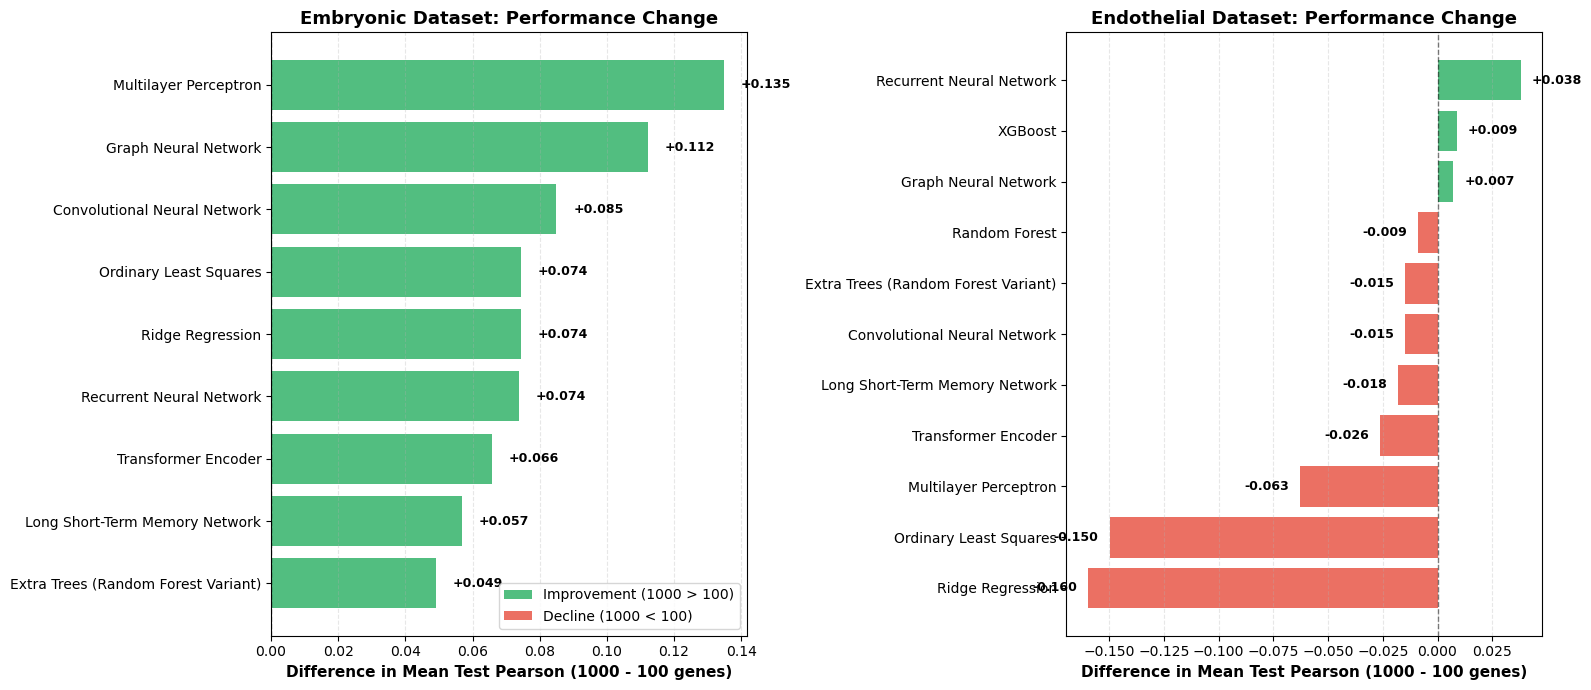


Key Findings by Dataset:

Embryonic:
  Models that improved with 1000 genes: 9/9
  Models that declined with 1000 genes: 0/9
  Average change: +0.0807
  Median change: +0.0743
  Best improvement: +0.1349 (Multilayer Perceptron)
  Worst decline: +0.0490 (Extra Trees (Random Forest Variant))

Endothelial:
  Models that improved with 1000 genes: 3/11
  Models that declined with 1000 genes: 8/11
  Average change: -0.0365
  Median change: -0.0150
  Best improvement: +0.0380 (Recurrent Neural Network)
  Worst decline: -0.1597 (Ridge Regression)


In [10]:
# Create a difference plot showing improvement/decline from 100 to 1000 genes for both datasets
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for idx, dataset in enumerate(['Embryonic', 'Endothelial']):
    ax = axes[idx]
    
    # Get comparison data with both 100 and 1000 gene runs
    dataset_comp = df_comparison[(df_comparison['dataset'] == dataset) & 
                                  (df_comparison['pearson_100'].notna()) & 
                                  (df_comparison['pearson_1000'].notna())]
    
    if len(dataset_comp) == 0:
        ax.text(0.5, 0.5, f'No {dataset} data with both 100 and 1000 genes', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{dataset} Dataset', fontsize=14, fontweight='bold')
        continue
    
    dataset_comp_sorted = dataset_comp.sort_values('difference', ascending=True)
    
    models = dataset_comp_sorted['model'].values
    differences = dataset_comp_sorted['difference'].values
    
    # Create color map: red for negative (worse), green for positive (better)
    colors = ['#27ae60' if d > 0 else '#e74c3c' for d in differences]
    
    y_pos = np.arange(len(models))
    bars = ax.barh(y_pos, differences, color=colors, alpha=0.8)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(models, fontsize=10)
    ax.set_xlabel('Difference in Mean Test Pearson (1000 - 100 genes)', fontsize=11, fontweight='bold')
    ax.set_title(f'{dataset} Dataset: Performance Change', fontsize=13, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, diff) in enumerate(zip(bars, differences)):
        width = bar.get_width()
        label_x = width + (0.005 if width > 0 else -0.005)
        ha = 'left' if width > 0 else 'right'
        ax.text(label_x, bar.get_y() + bar.get_height()/2, 
                f'{diff:+.3f}', ha=ha, va='center', fontsize=9, fontweight='bold')
    
    # Add legend only on the first plot
    if idx == 0:
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#27ae60', alpha=0.8, label='Improvement (1000 > 100)'),
            Patch(facecolor='#e74c3c', alpha=0.8, label='Decline (1000 < 100)')
        ]
        ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

# Store in FIGURES dict if it exists
if 'FIGURES' in globals():
    FIGURES['difference_100_vs_1000_genes'] = fig
    
# Print summary for both datasets
print("\nKey Findings by Dataset:")
print("="*80)

for dataset in ['Embryonic', 'Endothelial']:
    dataset_comp = df_comparison[(df_comparison['dataset'] == dataset) & 
                                  (df_comparison['pearson_100'].notna()) & 
                                  (df_comparison['pearson_1000'].notna())]
    
    if len(dataset_comp) == 0:
        print(f"\n{dataset}: No data with both 100 and 1000 genes")
        continue
    
    differences = dataset_comp['difference'].values
    models = dataset_comp['model'].values
    
    improved = (differences > 0).sum()
    declined = (differences < 0).sum()
    
    print(f"\n{dataset}:")
    print(f"  Models that improved with 1000 genes: {improved}/{len(differences)}")
    print(f"  Models that declined with 1000 genes: {declined}/{len(differences)}")
    print(f"  Average change: {differences.mean():+.4f}")
    print(f"  Median change: {np.median(differences):+.4f}")
    print(f"  Best improvement: {differences.max():+.4f} ({models[differences.argmax()]})")
    print(f"  Worst decline: {differences.min():+.4f} ({models[differences.argmin()]})")